# Tarea Final - Embeddings And Transformers

### ITESM - Escuela de Ingeniería y Ciencias
#### Maestría en Ciencias Computacionales
#### Tópicos AI 2
##### Dr. Luis Eduardo Falcón Morales

---

## Carlos E. Hdz Rincón - A01181616

# Introducción

Esta Tarea se podrá resolver de manera individual o en equipos de máximo 3 integrantes.

En los siguientes ejercicios se usará el mismo conjunto de datos del archivo `amazon_baby.csv` que usaste en la Tarea 2. Igualmente puedes apoyarte en los resultados obtenidos en dicha Tarea en relación a la limpieza de los datos.


# Prerequisitos y preparación de ambiente

## Instalación de dependencias

Descomentamos la siguiente línea para poder instalar las dependencias de Python necesarias.

In [ ]:
!pip install keras tensorflow matplotlib numpy pandas transformers spacy torch tqdm imbalanced-learn datasets
!python3 -m spacy download en_core_web_lg

## Definición de variables de ambiente y descarga de archivos

In [ ]:
# Set this variable to the root path of where the CSV files are located
%env DATA_LOCATION=/content/drive/MyDrive/Colab Notebooks/TopicosAI2/Assignments
!echo $DATA_LOCATION

# Set this to a folder where you'll like to cache the pretrained models
%env HF_HOME=/content/drive/MyDrive/Datasets/huggingface
!echo $HF_HOME

!ls -lah "$DATA_LOCATION"

In [ ]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip -P "${DATA_LOCATION}"
#!unzip "${DATA_LOCATION}/glove.6B.zip" -d "${DATA_LOCATION}"
#!rm "${DATA_LOCATION}/glove.6B.100d.txt"
#!rm "${DATA_LOCATION}/glove.6B.200d.txt"
#!rm "${DATA_LOCATION}/glove.6B.300d.txt"
#!rm "${DATA_LOCATION}/glove.6B.zip"
#!ls -lah "${DATA_LOCATION}"

## Imports

In [ ]:
from IPython.display import display

import csv
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import torch
import pandas as pd

from transformers import TFBertForQuestionAnswering, BertTokenizer,AutoTokenizer, AutoModelForQuestionAnswering, pipeline, TFAutoModelForQuestionAnswering, TFDistilBertForSequenceClassification
import spacy
import en_core_web_lg
from scipy.spatial import distance

#import sklearn
from sklearn.model_selection import train_test_split  
from sklearn.metrics import confusion_matrix, classification_report

from keras import regularizers
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences

import tqdm

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler



# --------------

import time
import random
import os
import re


import itertools 
from itertools import chain

import pickle

from keras.preprocessing.text import one_hot, Tokenizer

# Connect to Google Drive if hosting the files there
#from google.colab import drive
#drive.mount('/content/drive')

## Tools

In [ ]:
negative_words = ['no', 'nor', 'not',
                  'ain', "ain't", "aint",
                  'aren', "aren't", "arent",
                  'don', "don't", "dont",
                  'couldn', "couldn't", "couldnt",
                  'didn', "didn't", "didnt",
                  'doesn', "doesn't", "doesnt",
                  'hadn', "hadn't", "hadnt",
                  'hasn', "hasn't", "hasnt",
                  'haven', "haven't", "havent",
                  'isn', "isn't",  "isnt",
                  'mightn', "mightn't", "mightnt",
                  'mustn', "mustn't", "mustnt",
                  'needn', "needn't", "neednt",
                  'shan', "shan't", "shant",
                  'shouldn', "shouldn't", "shouldnt",
                  'wasn', "wasn't", "wasnt",
                  'weren', "weren't", "werent",
                  'won', "won't", "wont",
                  'wouldn', "wouldn't", "wouldnt",
                  "can't", "cant"]

my_stopwords = [ w for w in stopwords.words('english') if w not in negative_words]
#my_stopwords = stopwords.words("english")

In [ ]:
def print_marquee(msg: str):
    """
    Prints a centered message with a marquee of * 
    """
    marquee_width = len(msg) + 4
    print("\n")
    print("*" * marquee_width)
    print(f"* {msg} *")
    print("*" * marquee_width)

def plot_histogram(df: pd.DataFrame, nrows: int, ncols: int):
    """
    Plots a series of histograms for a dataframe in a nrows x ncols distribution
    """
    fig, ax = plt.subplots(nrows=nrows,
                           ncols=ncols,
                           figsize=(14,14))
    
    for n, col in enumerate(df.columns):
        plt.subplot(nrows, ncols, n+1)
        df[col].plot.hist(ax = plt.gca(),
                          bins=20,
                          legend=True)

In [ ]:
def model_2_pkl(model, filename: str):
    """Exports a model to PKL format"""
    pickle.dump(model, open(filename, 'wb'))

def pkl_2_model(filename: str):
    """Loads a model from a PKL file"""
    return pickle.load(open(filename, 'rb'))

def train_model(model_to_fit: tf.keras.models.Model,
                epochs: int,
                train_data: tuple,
                validation_data: tuple,
                callbacks: list = None,
                batch_size=None):

    t = time.process_time()
    
    trained_model = model_to_fit.fit(train_data[0],
                                     train_data[1],
                                     validation_data=validation_data,
                                     epochs=epochs,
                                     callbacks=callbacks,
                                     batch_size=batch_size)
    
    elapsed_time = time.process_time() - t
    
    print(f"\n\n ********* Training time: {elapsed_time} s.")
    return trained_model

def graph_loss_accuracy(h_model,
                        subtitle: str = ""):
    
    num_records = len(h_model.history["accuracy"])
    
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0,num_records),h_model.history["accuracy"],label="train_acc")
    plt.plot(np.arange(0,num_records),h_model.history["val_accuracy"],label="val_acc")
    plt.title("Training and Validation Accuracy" 
              + f" ({subtitle})" if subtitle else "")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.figure()
    plt.plot(np.arange(0,num_records),h_model.history["loss"],label="train_loss") 
    plt.plot(np.arange(0,num_records),h_model.history["val_loss"],label="val_loss")
    plt.title("Training and Validation Loss" 
              + f" ({subtitle})" if subtitle else "")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

# Helper functions for reporting

def print_dataset_prediction_report(y_pred,
                                    y_real,
                                    labels: list=None):
    
    #y_pred = np.round(y_pred).astype(int)

    print_marquee("Classification Report")
    print(classification_report(y_real,
                                y_pred,
                                target_names=labels))
    
    print_marquee("Confusion Matrix")
    print(confusion_matrix(y_real,
                           y_pred))


def evaluate_model(model_to_fit: tf.keras.models.Model,
                   epochs: int,
                   train_tuple: tuple,
                   validation_tuple: tuple,
                   test_tuple: tuple = None,
                   callbacks: list = None,
                   batch_size = None,
                   labels: list = None) -> tf.keras.models.Model:

    trained_model_history = train_model(model_to_fit,
                                epochs,
                                train_tuple,
                                validation_tuple,
                                callbacks=callbacks,
                                batch_size=batch_size)
    print_marquee("Model Summary")                                
    model_to_fit.summary()

    print_marquee("Validation Dataset Confusion Matrix")

    val_model_predictions = model_to_fit.predict(validation_tuple[0],
                                                 batch_size=batch_size)
    
    print_dataset_prediction_report(val_model_predictions.argmax(axis=1),
                                    validation_tuple[1].argmax(axis=1),
                                    labels)


    if test_tuple:

        print_marquee("Test Dataset Confusion Matrix")

        test_model_predictions = model_to_fit.predict(test_tuple[0],
                                                      batch_size=batch_size)
        
        print_dataset_prediction_report(test_model_predictions.argmax(axis=1),
                                        test_tuple[1].argmax(axis=1),
                                        labels)

    print_marquee("Train/Val Accuracy and Loss graphs")

    # If using early stopping, it might be the case that we used less epochs than
    #  requested
    subtitle = f"Epochs: {len(trained_model_history.history['accuracy'])}"
    
    graph_loss_accuracy(trained_model_history,
                        subtitle=subtitle)
    
    return model_to_fit, trained_model_history

In [ ]:
def clean_text(txt: str,
               stopwords: list = [],
               token_min_length: int = None,
               stemmer = None) -> str:
    # Remove <code> tags make sure that the . char matches all characters
    code_regex = re.compile("<code>.*?<\/code>", re.DOTALL)
    txt = re.sub(code_regex, "", txt)

    # Remove HTML
    html_regex = re.compile('<.*?>')
    txt = re.sub(html_regex, '', txt)

    # To lower
    txt = txt.lower()

    # Reduce multiple spaces to just one
    multiple_spaces_regex = " +"
    txt = re.sub(multiple_spaces_regex, ' ', txt).strip()

    # Optionally remove stop words
    if stopwords:
        txt = " ".join([t for t in txt.split() if t not in stopwords])

    # Remove non-alphanumeric characters
    non_alphanumeric_regex = "[^a-zA-Z0-9 ]"
    txt = re.sub(non_alphanumeric_regex, '', txt)

    if token_min_length:
        txt = " ".join([t for t in txt.split() if len(t) >= token_min_length])

    if stemmer:
        txt = " ".join([stemmer.stem(t) for t in txt.split()])

    # Remove any extra spaces that may have been left behind
    multiple_spaces_regex = " +"
    txt = re.sub(multiple_spaces_regex, ' ', txt).strip()

    return txt


def clean_up_column(data: pd.DataFrame,
                    column_to_clean: str,
                    stop_words: list = [],
                    token_min_length: int = 2,
                    stemmer = None,
                    print_data_preview: bool = True,
                    create_data_copy: bool = True) -> tuple:

    data_new = data.copy() if create_data_copy else data


    data_new[column_to_clean] = data_new[column_to_clean].apply(lambda row_text: clean_text(row_text,
                    stopwords = stop_words,
                    token_min_length = token_min_length,
                    stemmer = stemmer))


    if print_data_preview:
        print_marquee("Data")
        display(data_new[[column_to_clean]].head(5))

    return data_new


def get_token_sequences(train: pd.DataFrame,
                        val: pd.DataFrame,
                        test: pd.DataFrame,
                        column_to_process: str,
                        min_freq: int = 50):

    tokenizer = Tokenizer(
        num_words=None,
        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
        lower=True,
        split=" ",
        char_level=False,
        oov_token="[OOV]"
    )

    # Create a temporal copy so as to not affect the original DataFrame
    train = train.copy()

    tokenizer.fit_on_texts(train[column_to_process])

    # Remove 1 as the tokenizer reserves but doesn't use index 0
    raw_vocab_size = len(tokenizer.word_index) - 1

    print_marquee("Raw Vocabulary Statistics")

    print(f"Raw vocabulary size: {raw_vocab_size}")

    # Let's plot the graph of the dictionary size from more frequent to less frequent
    plt.plot(list(np.arange(raw_vocab_size)), list(tokenizer.word_docs.values()), color='blue')
    plt.show()

    # Let's reduce the list of words to those that happen at least min_freq

    my_vocab = {word: count for word, count in tokenizer.word_docs.items() if count >= min_freq}

    print_marquee(f"My vocabulary reduced to words that happen at least {min_freq} times")

    print(f"New vocabulary size reduced to words happening at least {min_freq} times: {len(my_vocab)}")
    print(f"Represents a reduction of {(1 - len(my_vocab)/raw_vocab_size) * 100}% \n")

    plt.plot(list(np.arange(len(my_vocab))), list(my_vocab.values()), color='blue')
    plt.show()

    # Filter out words not in vocabulary
    train[column_to_process] = train[column_to_process].apply(lambda row_text: filter_words_not_in_vocab(row_text, my_vocab))

    # Create another tokenizer based on the newly formed vocabulary
    tokenizer = Tokenizer(
        num_words=len(my_vocab),
        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
        lower=True,
        split=" ",
        char_level=False,
        oov_token="[OOV]"
    )

    tokenizer.fit_on_texts(train[column_to_process])

    train_sequences = tokenizer.texts_to_sequences(train[column_to_process])
    validation_sequences = tokenizer.texts_to_sequences(val[column_to_process])
    test_sequences = tokenizer.texts_to_sequences(test[column_to_process])

    print_marquee("My Vocabulary Tokenizer Statistics")

    # We need to substract 1 to account for the 0-index unused token (Keras reserves this but doesn't use it)
    print(f"Tokenizer vocabulary size: {len(tokenizer.word_index) - 1} (compared to {len(my_vocab)} of the my vocab size)")

    return train_sequences, validation_sequences, test_sequences


def calculate_document_length_metrics(data: list):
    train_doc_len = pd.Series([len(doc.split()) for doc in data])

    print_marquee("Data Metrics")
    print(f"Number of documents: {len(train_doc_len)}")
    print(f"Min length: {train_doc_len.min()}")
    print(f"Max length: {train_doc_len.max()}")
    print(f"Mean length: {train_doc_len.mean()}")
    print(f"Std Dev of length: {train_doc_len.std()}")

# 1

Existe una modelo pre-entrenado para Español generado por la Universidad de Chile, llamado BETO:

* https://github.com/dccuchile/beto
* https://users.dcc.uchile.cl/~jperez/papers/pml4dc2020.pdf

Utiliza la información de los datos y ejemplo en github que proporciona dicha liga para, con base al texto de Amado Nervo incluído al final de este documento, contestar las siguientes preguntas:

1. ¿Qué edad tenía cuando murió su padre?
1. ¿Qué eventos marcaron su vida?
1. ¿Qué lo llevó a aceptar un trabajo de escritorio?
1. ¿De qué nacionalidad era Amado Nervo?
1. ¿En qué fecha nació?
1. ¿En qué fecha murió?
1. ¿Cuál era el nombre de pila de Amado Nervo?
1. ¿Quién era Amado Nervo?
1. ¿De qué profesión era Amado Nervo?
1. ¿Qué estudió Amado Nervo?

En aquellas respuestas que consideres no fueron del todo adecuadas, incluye la gráfica de valores de los tokens con mayor peso de inicio y de terminación de la respuesta. Esto te puede ayudar a identificar otras posibles respuestas que pudieras ser más adecuadas para la respuesta buscada.

Igualmente puedes despegar simplemente los tokens o palabras con mayor peso de inico o terminación de la respuesta.

---
---

## Texto para la Pregunta 1 extraído de la biografía de Amado Nervo

https://es.wikipedia.org/wiki/Amado_Nervo

Amado Nervo (Tepic, en el Distrito Militar del mismo nombre desde 1867 hoy Nayarit; 27 de agosto de 18701-Montevideo, Uruguay; 24 de mayo de 1919), cuyo nombre completo era Amado Ruiz de Nervo Ordaz, fue un poeta y escritor mexicano, perteneciente al movimiento modernista. Fue miembro correspondiente de la Academia Mexicana de la Lengua pero no pudo serlo de número por residir en el extranjero.

Cuando tenía nueve años murió su padre, dejando a la familia en situación económica comprometida. Otras dos muertes han de marcar su vida: el suicidio de su hermano Luis, que también era poeta, y el retorno "a la fuente de gracia de donde procedía" de su amada Ana Cecilia Luisa Daillez.

Cursó sus primeros estudios en Michoacán; primero en Jacona, en el Colegio de San Luis Gonzaga, donde se destacó por su inteligencia y cumplimiento, después en Zamora estudió ciencias, filosofía y el primer año de leyes en el Seminario aun cuando abandonó los estudios rápidamente en 1891. Las urgencias económicas le hicieron desistir y lo obligaron a aceptar un trabajo de escritorio en Tepic y trasladarse después a Mazatlán, donde alternaba sus deberes en el despacho de un abogado con sus artículos para El Correo de la Tarde. 

In [ ]:
# Reference docs
# https://huggingface.co/transformers/usage.html#extractive-question-answering
def answer_question(question: str,
                    text: str,
                    model: TFBertForQuestionAnswering,
                    tokenizer,
                    is_tf: bool = True) -> tuple:

    # Apply the tokenizer to the input text, treating them as a text-pair.
    input = tokenizer.encode_plus(question, text,
                                  add_special_tokens=True,
                                  return_tensors = "tf" if is_tf else "pt")
    input_ids = input["input_ids"].numpy().tolist()[0] if is_tf else input["input_ids"].tolist()[0]
    # print('The input has a total of {:} tokens.'.format(len(input_ids)))

    # BERT only needs the token IDs, but for the purpose of inspecting the 
    #  tokenizer's behavior, let's also get the token strings and display them.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # The number of segment A tokens includes the [SEP] token istelf.
    num_seg_a = sep_index + 1

    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0] * num_seg_a + [1] * num_seg_b

    # There should be a segment_id for every input token.
    assert len(segment_ids) == len(input_ids)

    # Use the BERT model to make predictions on the start/end idx for the answer
    outputs = model(**input,
                    return_dict=True)
        
    start_scores = outputs.start_logits
    end_scores = outputs.end_logits

    if is_tf:
        # Find the tokens with the highest `start` and `end` scores.
        answer_start = tf.argmax(start_scores, axis=1)[0]
        answer_end = tf.argmax(end_scores, axis=1)[0] + 1

    else:
        answer_start = torch.argmax(start_scores).item()
        answer_end = torch.argmax(end_scores).item() + 1

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    metadata = {
        "start_scores": start_scores,
        "end_scores": end_scores,
        "tokens": tokens
    }

    return answer, metadata


def plot_answer_output_probability(start_scores,
                                   end_scores,
                                   tokens,
                                   title: str = "",
                                   max_vals: int = None):
    title = f"{title} - " if title else ""
    sns.set(style='darkgrid')

    #sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (32,8)

    s_scores = start_scores.detach().numpy().squeeze() if isinstance(start_scores, torch.Tensor) else start_scores.numpy().squeeze()
    e_scores = end_scores.detach().numpy().squeeze() if isinstance(end_scores, torch.Tensor) else end_scores.numpy().squeeze()

    # tokens identificados de manera única en el eje-x
    token_labels = []
    for (i, token) in enumerate(tokens):
        token_labels.append('{:} - {:>2}'.format(token, i))

    s_tokens = np.array(token_labels)
    e_tokens = np.array(token_labels)

    # Filter and keep only the top max_vals if necessary
    if max_vals:
        s_max_idx = s_scores.argsort()[-max_vals:][::-1]
        e_max_idx = e_scores.argsort()[-max_vals:][::-1]
        
        s_scores = s_scores[s_max_idx]
        s_tokens = s_tokens[s_max_idx]

        e_scores = e_scores[e_max_idx]
        e_tokens = e_tokens[e_max_idx]

    ax = sns.barplot(x=s_tokens, y=s_scores, ci=None)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
    ax.grid(True)
    plt.title(f'{title}Start_Word scores')

    plt.show()

    ax = sns.barplot(x=e_tokens, y=e_scores, ci=None)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
    ax.grid(True)
    plt.title(f'{title}End_Word scores')

    plt.show()


## Extracción de respuestas usando ArgMax

In [ ]:
model_id = "mrm8488/distill-bert-base-spanish-wwm-cased-finetuned-spa-squad2-es"

# This is a pytorch-based model
amado_model = AutoModelForQuestionAnswering.from_pretrained(model_id)
amado_tokenizer = AutoTokenizer.from_pretrained(model_id,
                                                use_fast=False,
                                                strip_accents=False,
                                                clean_text=True,
                                                do_lower_case=False,
                                                #do_basic_tokenize=True
                                                )
print(f"Tokenizer vocabulary size for {model_id}: {amado_tokenizer.vocab_size}\n\n")

amado_bio = "Amado Nervo (Tepic, en el Distrito Militar del mismo nombre desde 1867 hoy Nayarit; 27 de agosto de 1871 - Montevideo, Uruguay; 24 de mayo de 1919), cuyo nombre completo era Amado Ruiz de Nervo Ordaz, fue un poeta y escritor mexicano, perteneciente al movimiento modernista. Fue miembro correspondiente de la Academia Mexicana de la Lengua pero no pudo serlo de número por residir en el extranjero. Cuando tenía nueve años murió su padre, dejando a la familia en situación económica comprometida. Otras dos muertes han de marcar su vida: el suicidio de su hermano Luis, que también era poeta, y el retorno 'a la fuente de gracia de donde procedía' de su amada Ana Cecilia Luisa Daillez. Cursó sus primeros estudios en Michoacán; primero en Jacona, en el Colegio de San Luis Gonzaga, donde se destacó por su inteligencia y cumplimiento, después en Zamora estudió ciencias, filosofía y el primer año de leyes en el Seminario aun cuando abandonó los estudios rápidamente en 1891. Las urgencias económicas le hicieron desistir y lo obligaron a aceptar un trabajo de escritorio en Tepic y trasladarse después a Mazatlán, donde alternaba sus deberes en el despacho de un abogado con sus artículos para El Correo de la Tarde."
amado_questions = [
                   "¿Qué edad tenía cuando murió su padre?",
                   "¿Qué eventos marcaron su vida?",
                   "¿Qué lo llevó a aceptar un trabajo de escritorio?",
                   "¿De qué nacionalidad era Amado Nervo?",
                   "¿En qué fecha nació?",
                   "¿En qué fecha murió?",
                   "¿Cuál era el nombre de pila de Amado Nervo?",
                   "¿Quién era Amado Nervo?",
                   "¿De qué profesión era Amado Nervo?",
                   "¿Qué estudió Amado Nervo?",
                   "Dónde nació Amado Nervo?",
                   "A qué movimiento pertenecía?"
]

print_marquee("Answering questions about Amado Nervo")

answer_metadata = []

for idx, q in enumerate(amado_questions):
    ans, metadata = answer_question(q,
                                    amado_bio,
                                    amado_model,
                                    amado_tokenizer,
                                    is_tf=False)

    answer_metadata.append((ans, metadata))

    print(f"{idx + 1}. {q}: \n{ans}\n\n")

Tokenizer vocabulary size for mrm8488/distill-bert-base-spanish-wwm-cased-finetuned-spa-squad2-es: 31002




*****************************************
* Answering questions about Amado Nervo *
*****************************************
1. ¿Qué edad tenía cuando murió su padre?: 
nueve años


2. ¿Qué eventos marcaron su vida?: 
el suicidio de su hermano Luis , que también era poeta , y el retorno [UNK] a la fuente de gracia de donde procedía [UNK] de su amada Ana Cecilia Luisa Daillez


3. ¿Qué lo llevó a aceptar un trabajo de escritorio?: 
urgencias económicas


4. ¿De qué nacionalidad era Amado Nervo?: 
mexicano


5. ¿En qué fecha nació?: 
[UNK] de agosto de [UNK]


6. ¿En qué fecha murió?: 
24 de mayo de 1919


7. ¿Cuál era el nombre de pila de Amado Nervo?: 
Amado Ruiz de Nervo Ordaz


8. ¿Quién era Amado Nervo?: 
Amado Ruiz de Nervo Ordaz


9. ¿De qué profesión era Amado Nervo?: 
poeta


10. ¿Qué estudió Amado Nervo?: 
ciencias , filosofía y el primer año de leyes


11. Dónde nació 

Para las preguntas 5 y 8 (índices 4 y 7) las respuestas parecen estar bien, pero
podrían estar mejor, inspeccionemos la gráfica de predicciones para ver qué otros tokens fueron candidatos.



*************************************************
* ¿En qué fecha nació?
[UNK] de agosto de [UNK] *
*************************************************


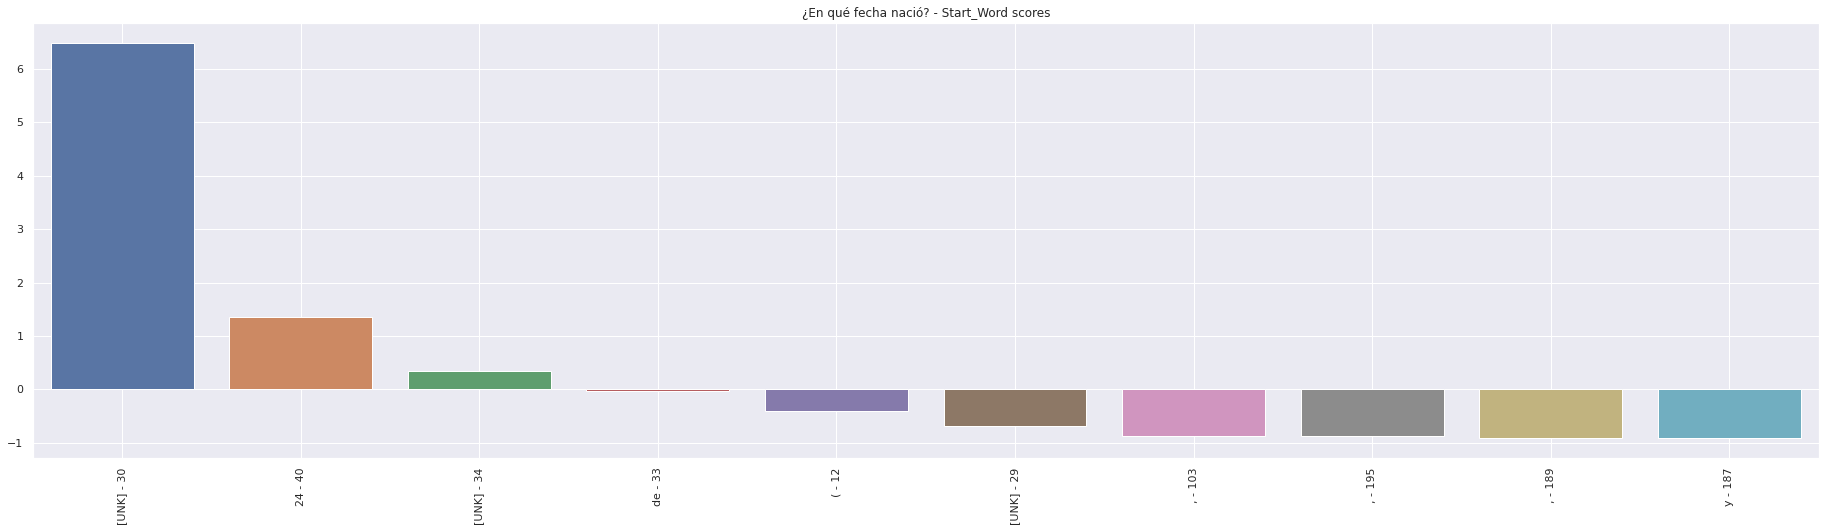

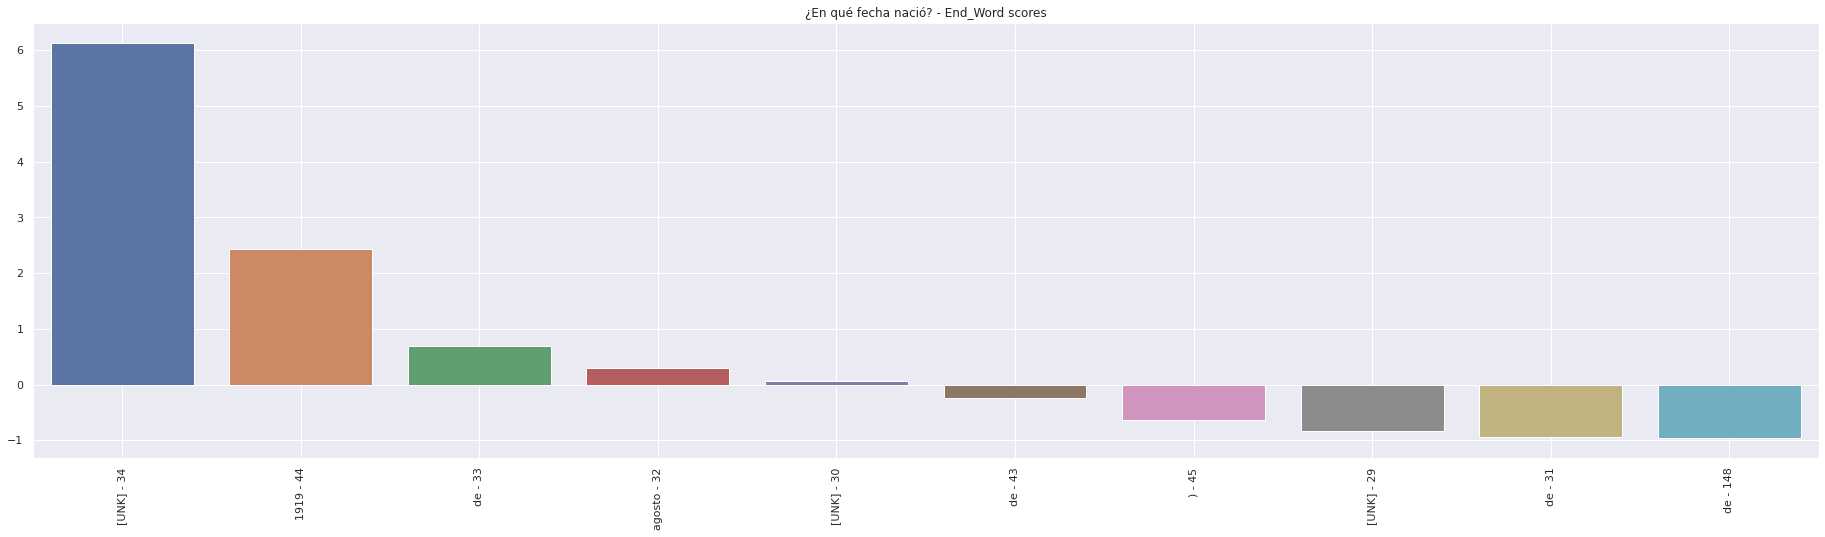



*****************************************************
* ¿Quién era Amado Nervo?
Amado Ruiz de Nervo Ordaz *
*****************************************************


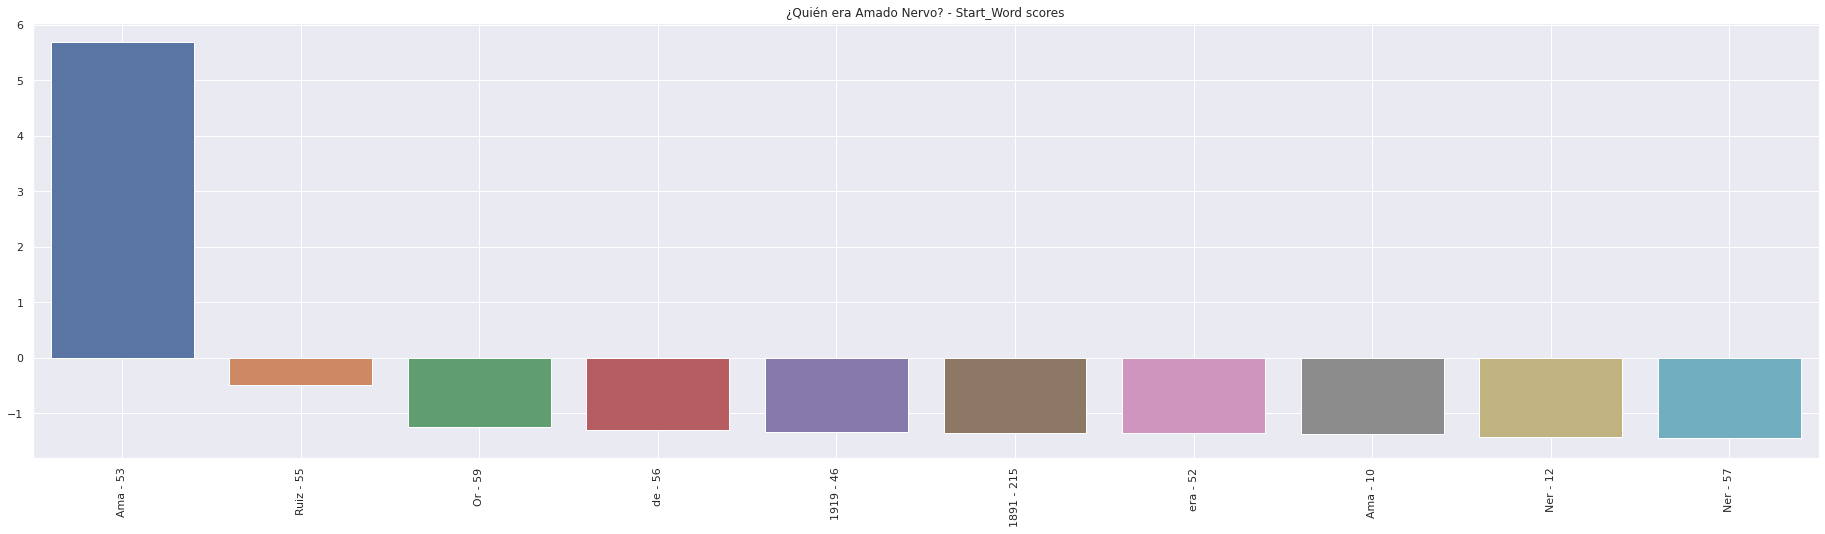

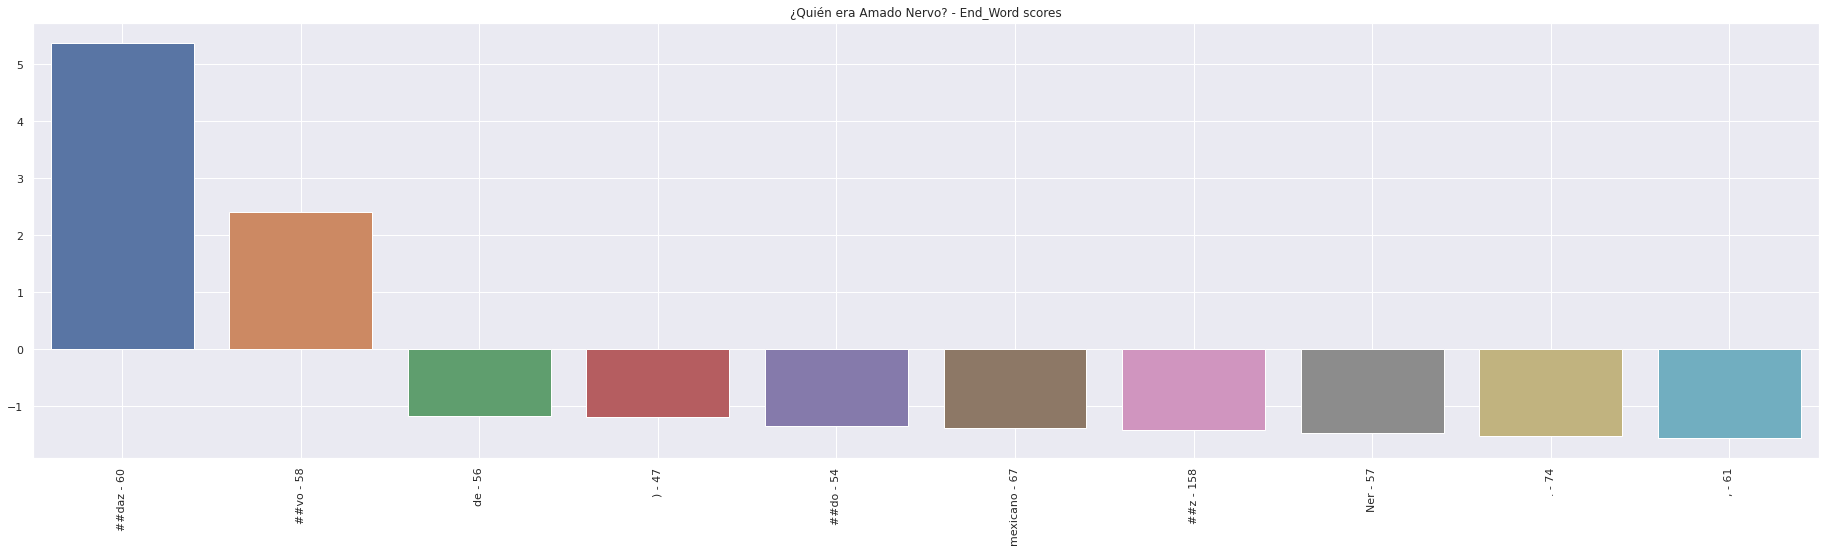

In [ ]:
for question_id in [4, 7]:
    
    q = amado_questions[question_id]
    ans, metadata = answer_metadata[question_id]

    print_marquee(f"{q}\n{ans}")

    plot_answer_output_probability(metadata["start_scores"],
                                   metadata["end_scores"],
                                   metadata["tokens"],
                                   title=q,
                                   max_vals=10
                                   )

## Extracción de respuestas usando Pipelines de Huggingface

Esta manera proporciona configuraciones por default para poder hacer la extracción de manera rápida y eficiente.

In [ ]:
model_id = "mrm8488/distill-bert-base-spanish-wwm-cased-finetuned-spa-squad2-es"

amado_bio = "Amado Nervo (Tepic, en el Distrito Militar del mismo nombre desde 1867 hoy Nayarit; 27 de agosto de 1871 - Montevideo, Uruguay; 24 de mayo de 1919), cuyo nombre completo era Amado Ruiz de Nervo Ordaz, fue un poeta y escritor mexicano, perteneciente al movimiento modernista. Fue miembro correspondiente de la Academia Mexicana de la Lengua pero no pudo serlo de número por residir en el extranjero. Cuando tenía nueve años murió su padre, dejando a la familia en situación económica comprometida. Otras dos muertes han de marcar su vida: el suicidio de su hermano Luis, que también era poeta, y el retorno 'a la fuente de gracia de donde procedía' de su amada Ana Cecilia Luisa Daillez. Cursó sus primeros estudios en Michoacán; primero en Jacona, en el Colegio de San Luis Gonzaga, donde se destacó por su inteligencia y cumplimiento, después en Zamora estudió ciencias, filosofía y el primer año de leyes en el Seminario aun cuando abandonó los estudios rápidamente en 1891. Las urgencias económicas le hicieron desistir y lo obligaron a aceptar un trabajo de escritorio en Tepic y trasladarse después a Mazatlán, donde alternaba sus deberes en el despacho de un abogado con sus artículos para El Correo de la Tarde."
amado_questions = [
                   "¿Qué edad tenía cuando murió su padre?",
                   "¿Qué eventos marcaron su vida?",
                   "¿Qué lo llevó a aceptar un trabajo de escritorio?",
                   "¿De qué nacionalidad era Amado Nervo?",
                   "¿En qué fecha nació?",
                   "¿En qué fecha murió?",
                   "¿Cuál era el nombre de pila de Amado Nervo?",
                   "¿Quién era Amado Nervo?",
                   "¿De qué profesión era Amado Nervo?",
                   "¿Qué estudió Amado Nervo?",
]

nlp_pipeline = pipeline(
    'question-answering', 
    model=model_id,
    tokenizer=(
        model_id,  
        {"use_fast": False}
    )
)

print_marquee("Answering questions about Amado Nervo")

answer_metadata = []

for idx, q in enumerate(amado_questions):

    # Output has the shape
    # Output: {'answer': 'español', 'end': 169, 'score': 0.67530957344621, 'start': 163}

    output = nlp_pipeline({
            'question': q,
            'context': amado_bio
         })
    
    ans = output["answer"]

    answer_metadata.append((ans, output))

    print(f"{idx + 1}. {q}: \n{ans}\n\n")



*****************************************
* Answering questions about Amado Nervo *
*****************************************
1. ¿Qué edad tenía cuando murió su padre?: 
nueve años


2. ¿Qué eventos marcaron su vida?: 
Otras dos muertes


3. ¿Qué lo llevó a aceptar un trabajo de escritorio?: 
urgencias económicas


4. ¿De qué nacionalidad era Amado Nervo?: 
mexicano,


5. ¿En qué fecha nació?: 
24 de mayo de 1919),


6. ¿En qué fecha murió?: 
24 de mayo de 1919),


7. ¿Cuál era el nombre de pila de Amado Nervo?: 
Amado Ruiz de Nervo Ordaz,


8. ¿Quién era Amado Nervo?: 
Amado Ruiz de Nervo Ordaz,


9. ¿De qué profesión era Amado Nervo?: 
poeta y escritor


10. ¿Qué estudió Amado Nervo?: 
ciencias, filosofía y el primer año de leyes




De la misma manera que en la técnica anterior, se observan algunas respuestas que no hacen mucho sentido, inspeccionemos los 10 mejores candidatos que el modelo determinó podrían ser buen punto de entrada y final de respuesta.



*************************************************
* ¿En qué fecha nació?
[UNK] de agosto de [UNK] *
*************************************************


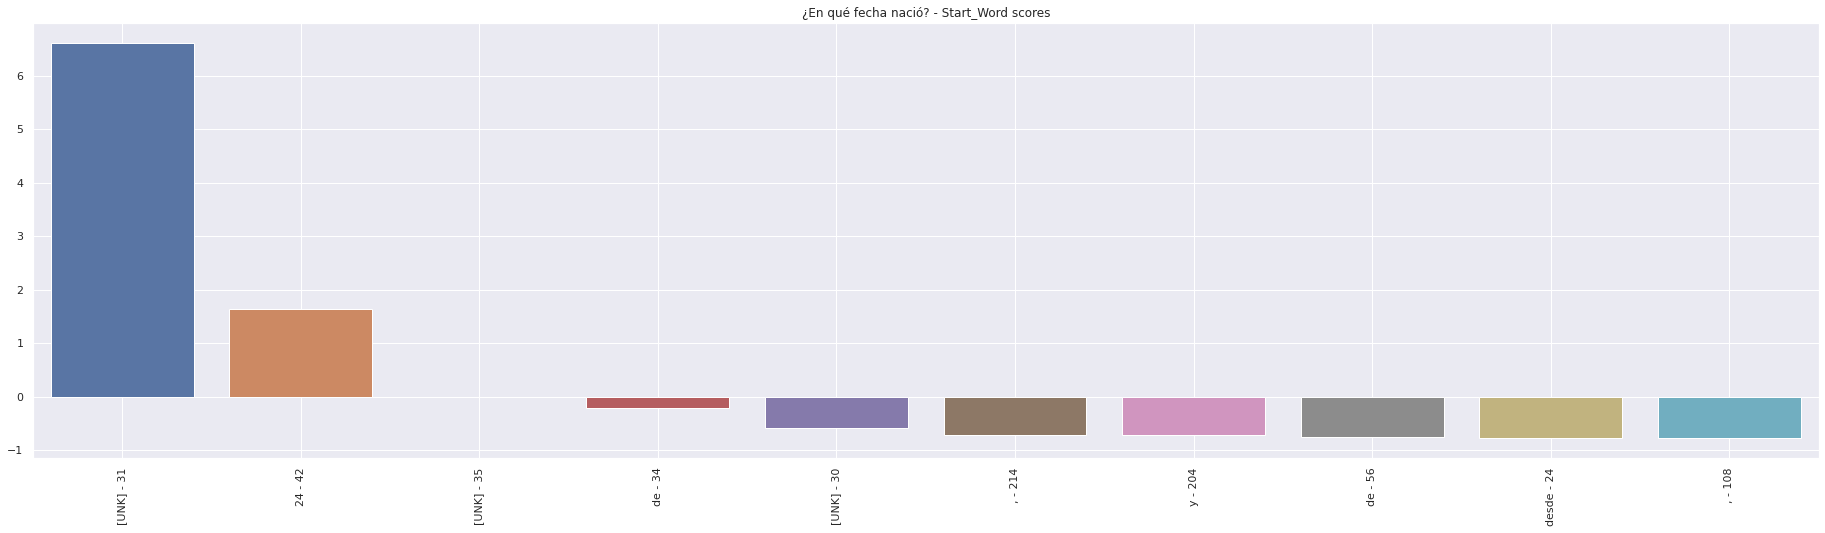

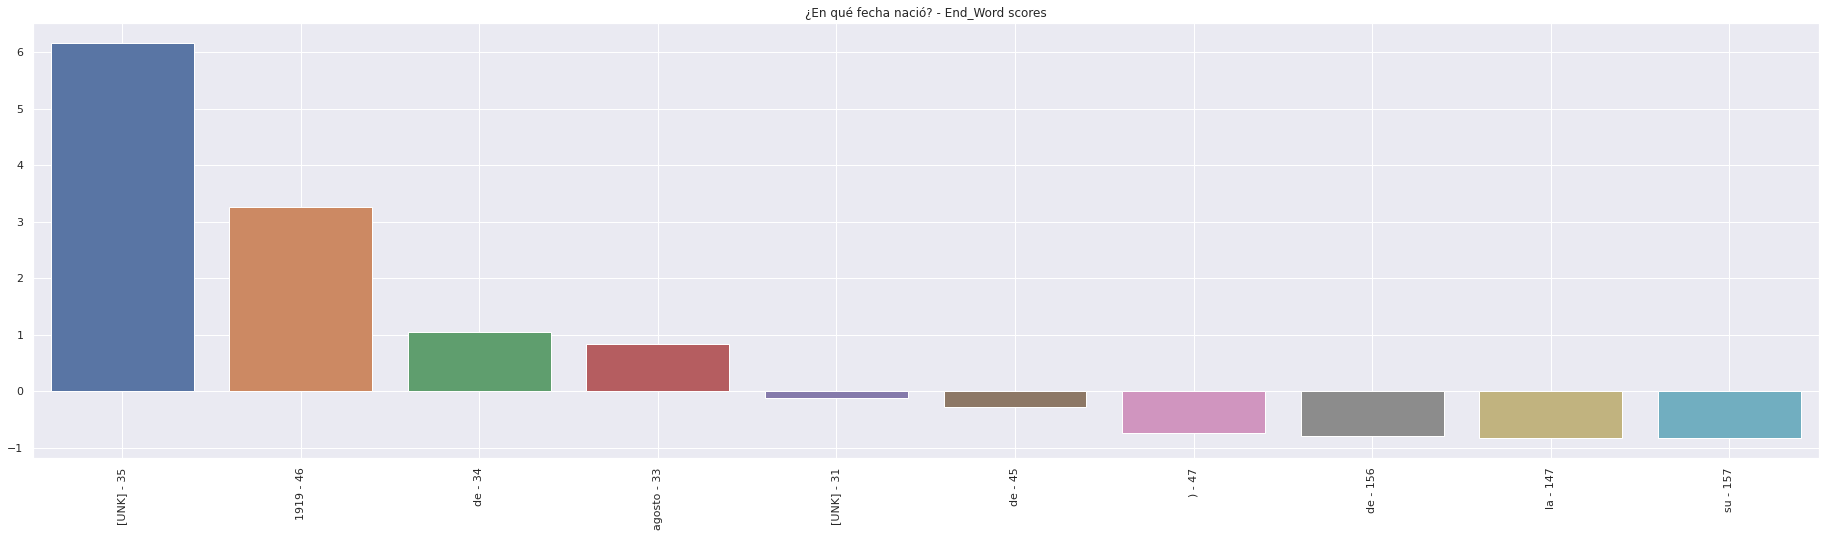



*****************************************************
* ¿Quién era Amado Nervo?
amado ruiz de nervo ordaz *
*****************************************************


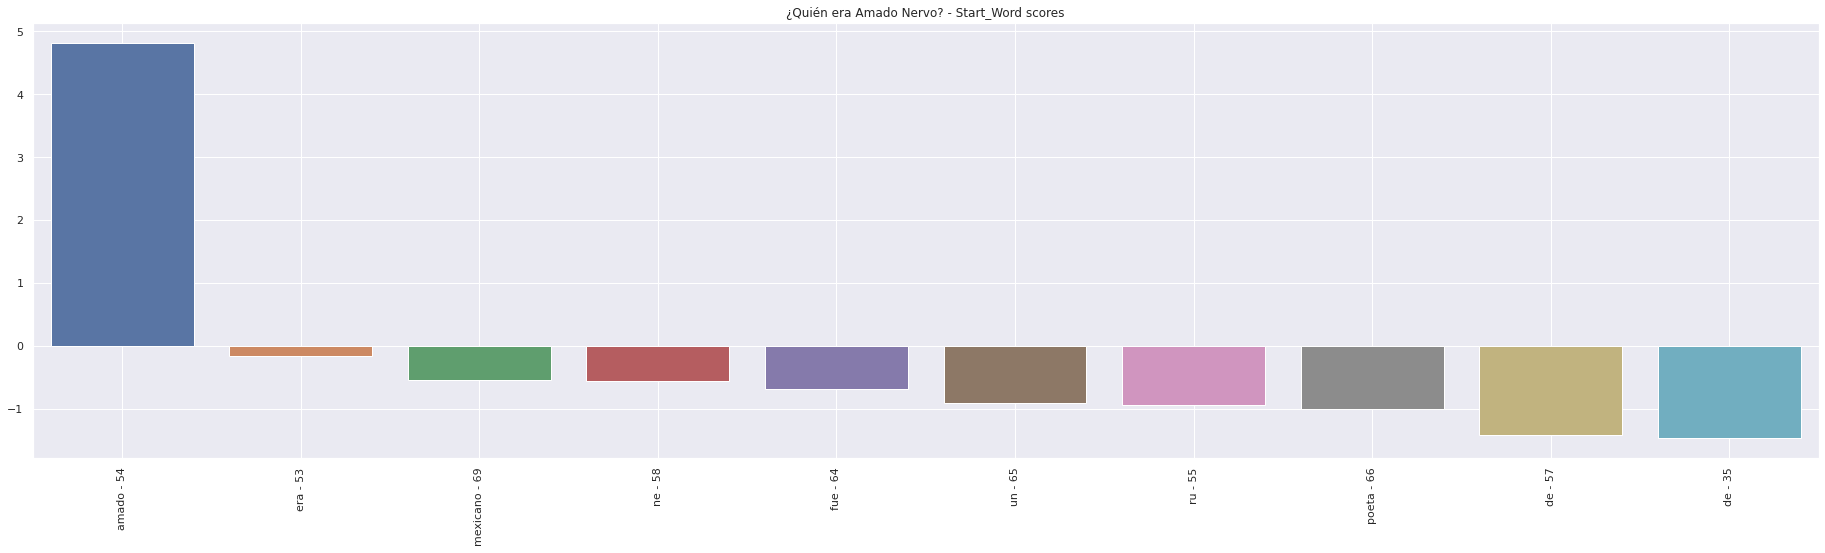

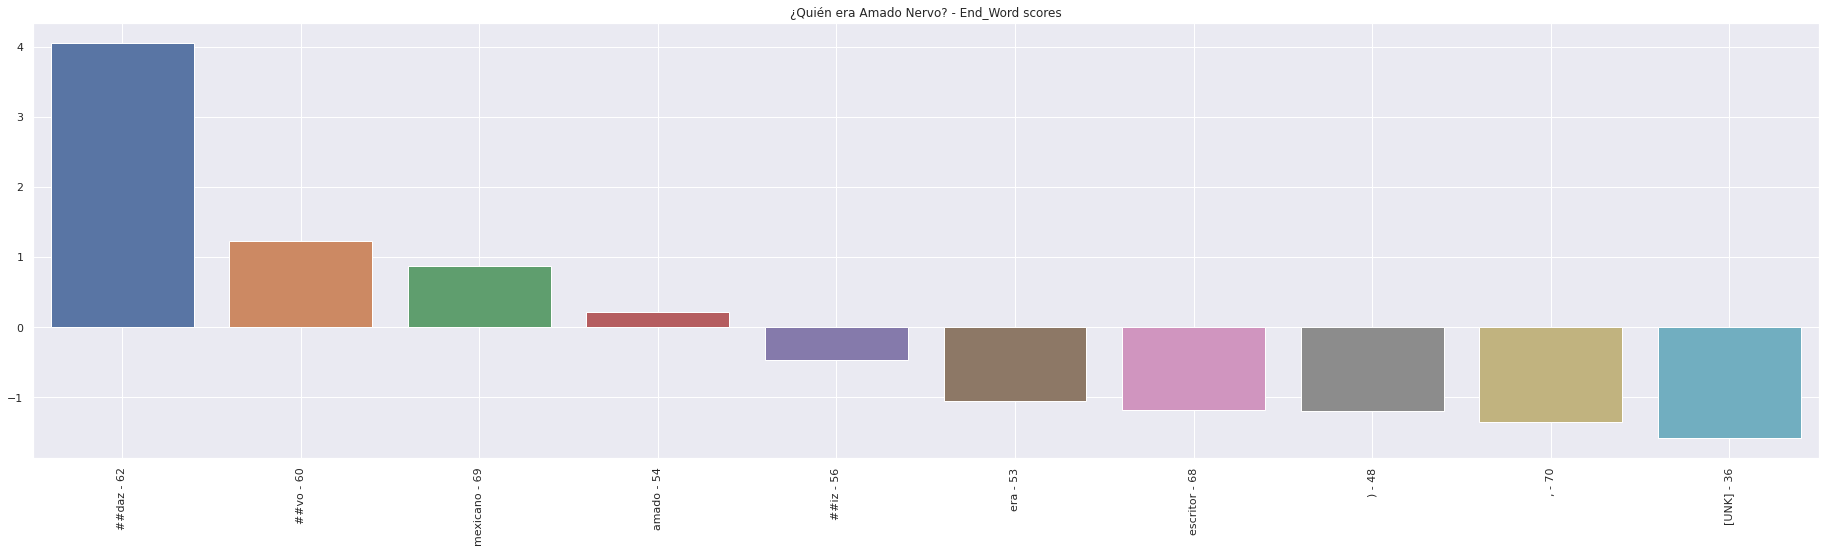

In [ ]:
for question_id in [4, 7]:
    
    q = amado_questions[question_id]
    ans, metadata = answer_metadata[question_id]

    print_marquee(f"{q}\n{ans}")

    plot_answer_output_probability(metadata["start_scores"],
                                   metadata["end_scores"],
                                   metadata["tokens"],
                                   title=q,
                                   max_vals=10
                                   )

## Experimentos

Los siguientes experimentos son ejercicios adicionales que se hicieron con diferentes modelos BERT.

En el primero se tradujo el modelo a inglés y se intentó hacer la extracción usando el modelo `bert-large-uncased-whole-word-masking-finetuned-squad`.

En el siguiente experimento se usó el modelo BETO para poder hacer la inferencia de tokens enmascarados en una oración.

### Amado Nervo en inglés con BERT

In [ ]:
amado_en_model = TFBertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
amado_en_tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

amado_en_bio = "Amado Nervo (Tepic, August 27, 1871 - Montevideo, Uruguay; May 24, 1919), whose full name was Amado Ruiz de Nervo Ordaz, was a mexican poet and writer, belonging to the modernist movement. He was a corresponding member of the Academia Mexicana de la Lengua but could not be a member of the number due to residing abroad. When he was nine years old his father died, leaving the family in a compromised economic situation. Two other deaths marked his life: the suicide of his brother Luis, who was also a poet, and the return 'to the source of grace from which he came' of his beloved Ana Cecilia Luisa Daillez. He attended his first studies in Michoacán; first in Jacona, in the Colegio de San Luis Gonzaga, where he stood out for his intelligence and dilligence, later in Zamora he studied science, philosophy and the first year of law at the Seminary even though he quickly abandoned his studies in 1891. Economic emergencies made him desist and forced him to accept a desk job in Tepic and later move to Mazatlán, where he alternated his duties in a lawyer's office with his articles for El Correo de la Tarde."

amado_en_questions = [
                    "How old was he when his father died?",
                    "What events marked his life?",
                    "What led him to accept a desk job?",
                    "What nationality was Amado Nervo?",
                    "On what date was he born?",
                    "On what date did he die?",
                    "What was Amado Nervo's first name?",
                    "Who was Amado Nervo?",
                    "What profession was Amado Nervo?",
                    "What did Amado Nervo study?"
]

answer_en_metadata = []

for idx, q in enumerate(amado_en_questions):
    ans, metadata = answer_question(q,
                                    amado_en_bio,
                                    amado_en_model,
                                    amado_en_tokenizer)

    answer_en_metadata.append((ans, metadata))

    print(f"{idx + 1}. {q}: \n{ans}\n\n")

All model checkpoint layers were used when initializing TFBertForQuestionAnswering.

All the layers of TFBertForQuestionAnswering were initialized from the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForQuestionAnswering for predictions without further training.


1. How old was he when his father died?: 
nine


2. What events marked his life?: 
two other deaths marked his life : the suicide of his brother luis


3. What led him to accept a desk job?: 
economic emergencies


4. What nationality was Amado Nervo?: 
mexican


5. On what date was he born?: 
august 27 , 1871


6. On what date did he die?: 
may 24 , 1919


7. What was Amado Nervo's first name?: 
amado ruiz de nervo ordaz


8. Who was Amado Nervo?: 
a mexican poet and writer


9. What profession was Amado Nervo?: 
poet and writer


10. What did Amado Nervo study?: 
science , philosophy and the first year of law




Se pueden observar excelentes resultados que en ocasiones son mejores que los obtenidos con BETO, esto puede deberse a que este modelo BERT fue entrenado con un *fine-tuning* más completo que el utilizado con BETO. P

### Inferencia de tokens enmascarados

In [ ]:
# create the tokenizer and the model
import torch
from transformers import BertForMaskedLM, BertTokenizer

tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased", do_lower_case=False)
model = BertForMaskedLM.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
e = model.eval()

text = "[CLS] Para solucionar los [MASK] de Chile, el presidente debe [MASK] de inmediato. [SEP]"
masked_indxs = (4,11)

tokens = tokenizer.tokenize(text)
indexed_tokens = tokenizer.convert_tokens_to_ids(tokens)
tokens_tensor = torch.tensor([indexed_tokens])

predictions = model(tokens_tensor)[0]

for i,midx in enumerate(masked_indxs):
    idxs = torch.argsort(predictions[0,midx], descending=True)
    predicted_token = tokenizer.convert_ids_to_tokens(idxs[:5])
    print('MASK',i,':',predicted_token)


MASK 0 : ['problemas', 'conflictos', 'motivos', '[UNK]', 'disturbios']
MASK 1 : ['actuar', 'reunirse', 'intervenir', 'asumir', 'iniciarse']


# 2

Utiliza el método de GloVe embedding para obtener la representación embebida de cada palabra de los comentarios del archivo amazon_baby. De preferencia utilizar la librería SpaCy (https://spacy.io/), (https://spacy.io/models/en) con los vectores embedidos de dimensión 300 como lo vimos en el ejercicio en clase.

NOTA: si tienes problemas de recursos de memoria, puedes usar los vectores de dimensión 50 que encuentras en la página de GloVe (https://nlp.stanford.edu/projects/glove/). 

## Carga de datos y limpieza

Se removeran aquellos registros que no poseen un review, sólo las columnas de `review` y `rating` nos servirán.

In [ ]:
data_root_location = os.environ["DATA_LOCATION"]

amazon_baby = pd.read_csv(f"{data_root_location}/amazon_baby.csv",
                          header=0)

display(amazon_baby.info())
display(amazon_baby.describe())

display(amazon_baby.head(5))

display(amazon_baby.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183531 entries, 0 to 183530
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   name    183213 non-null  object
 1   review  182702 non-null  object
 2   rating  183531 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.2+ MB


None

,rating
count,183531.000000
mean,4.120448
std,1.285017
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


name      318
review    829
rating      0
dtype: int64

Existen muchos registros que no tienen reviews, dado que tenemos suficientes ejemplos en el dataset que no son nulos, podemos remover esos registros.

In [ ]:
amazon_baby = amazon_baby[amazon_baby['review'].notna()]
display(amazon_baby.isnull().sum())

name      318
review      0
rating      0
dtype: int64

## Limpieza de reviews

Se eliminarán stopwords y se mantendrá los negativos

In [ ]:
print(f"Stopwords list length: {len(my_stopwords)}")

Stopwords list length: 139


In [ ]:
amazon_baby_clean = clean_up_column(amazon_baby,
                                    column_to_clean = "review",
                                    stop_words = my_stopwords,
                                    token_min_length = 2)

# Remove those records that after cleaning ended up with no reviews
amazon_baby_clean = amazon_baby_clean[amazon_baby_clean["review"].str.len() > 1]



********
* Data *
********


,review
0,flannel wipes ok opinion not worth keeping als...
1,came early not disappointed love planet wise b...
2,soft comfortable warmer looksfit full size bed...
3,product well worth purchase not found anything...
4,kids cried nonstop tried ween pacifier found t...


## Train/Val/Test Split

Para este modelo se utilizará un split de 80/10/10 para Train/Val/Test y nos aseguraremos de que las clases estén mas o menos balanceadas.

In [ ]:
def train_val_test_split(X: pd.DataFrame,
                         y: np.ndarray,
                         should_print_summary: bool = True,
                         balance_classes: bool = False):

    """Splits a dataset into an 80/10/10 Train/val/set split"""
    # Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        train_size=0.8,
                                                        random_state=42)
    # Val/Test split
    X_val, X_test, y_val, y_test = train_test_split(X_test,
                                                    y_test,
                                                    train_size=0.5,
                                                    random_state=42)

    # Ravel the labels to get it in better shape for the training
    y_train = y_train.ravel() - 1
    y_val = y_val.ravel() - 1
    y_test = y_test.ravel() - 1

    if should_print_summary:
        print(f"X_train: {X_train.shape}")
        print(f"X_val: {X_val.shape}")
        print(f"X_test: {X_test.shape}")

        print(f"y_train: {y_train.shape}")
        print(f"y_val: {y_val.shape}")
        print(f"y_test: {y_test.shape}")

    return X_train, X_val, X_test, y_train, y_val, y_test


X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(amazon_baby_clean[["review"]], # A Dataframe
                                                                      amazon_baby_clean["rating"]) # A Series

print(f'Train distribution dataset shape {dict(zip(*np.unique(y_train, return_counts=True)))}')
print(f'Val distribution dataset shape {dict(zip(*np.unique(y_val, return_counts=True)))}')
print(f'Test distribution dataset shape {dict(zip(*np.unique(y_test, return_counts=True)))}')

X_train: (146158, 1)
X_val: (18270, 1)
X_test: (18270, 1)
y_train: (146158,)
y_val: (18270,)
y_test: (18270,)
Train distribution dataset shape {0: 12086, 1: 9005, 2: 13488, 3: 26399, 4: 85180}
Val distribution dataset shape {0: 1493, 1: 1144, 2: 1613, 3: 3354, 4: 10666}
Test distribution dataset shape {0: 1537, 1: 1127, 2: 1626, 3: 3346, 4: 10634}


## Balance de clases

Veamos el balance de clases en el dataset de entrenamiento para determinar si debemos hacer algo para balancearlas

Train distribution dataset shape {0: 12086, 1: 9005, 2: 13488, 3: 26399, 4: 85180}


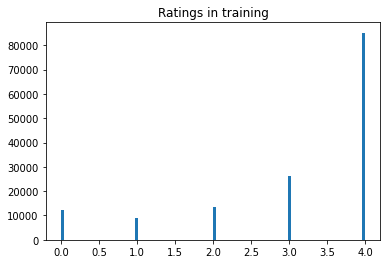

In [ ]:
print(f'Train distribution dataset shape {dict(zip(*np.unique(y_train, return_counts=True)))}')
_ = plt.hist(y_train, bins='auto')  # arguments are passed to np.histogram
plt.title("Ratings in training")
plt.show()

El balance de clases está cargado hacia las calificaciones de 5 estrellas, pero podemos corregir esto usando Oversampling.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Resampled dataset shape {0: 85180, 1: 85180, 2: 85180, 3: 85180, 4: 85180}


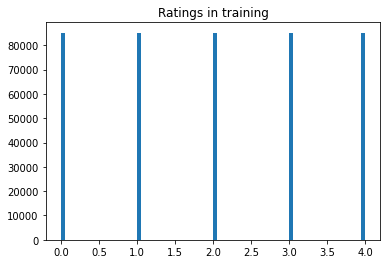

In [ ]:
undersampler = RandomUnderSampler(sampling_strategy='all',
                                  random_state=42)

oversampler = RandomOverSampler(sampling_strategy='auto',
                                  random_state=42)

X_train_res, y_train_res = oversampler.fit_resample(X_train,
                                                    y_train)

print(f'Resampled dataset shape {dict(zip(*np.unique(y_train_res.ravel(), return_counts=True)))}')

_ = plt.hist(y_train_res.ravel(), bins='auto')  # arguments are passed to np.histogram
plt.title("Ratings in training")
plt.show()

## One-hot encoding

Necesario para el funcionamiento de nuestros modelos

In [ ]:
 # Ravel the labels to get it in better shape for the training
X_train = X_train["review"].ravel()
X_train_res = X_train_res.ravel()
X_val = X_val["review"].ravel()
X_test = X_test["review"].ravel()

# One-hot encode the training, validation and test classes
y_train = tf.keras.utils.to_categorical(y_train)
y_train_res = tf.keras.utils.to_categorical(y_train_res.ravel())
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

print(f"X_train: {X_train.shape}")
print(f"X_train_res: {X_train_res.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")

print(f"y_train: {y_train.shape}")
print(f"y_train_res: {y_train_res.shape}")
print(f"y_val: {y_val.shape}")
print(f"y_test: {y_test.shape}")

X_train: (146158,)
X_train_res: (425900,)
X_val: (18270,)
X_test: (18270,)
y_train: (146158, 5)
y_train_res: (425900, 5)
y_val: (18270, 5)
y_test: (18270, 5)


## Tokenización

In [ ]:
amazon_baby_tokenizer = Tokenizer(
        num_words=None,
        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
        lower=True,
        split=" ",
        char_level=False,
        oov_token="[OOV]"
)

# Fit on the whole training corpus
amazon_baby_tokenizer.fit_on_texts(X_train)

word_index = amazon_baby_tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 131708 unique tokens.


In [ ]:
# Transform from text to sequences
train_sequences = amazon_baby_tokenizer.texts_to_sequences(X_train)
train_sequences_balanced = amazon_baby_tokenizer.texts_to_sequences(X_train_res)
val_sequences = amazon_baby_tokenizer.texts_to_sequences(X_val)
test_sequences = amazon_baby_tokenizer.texts_to_sequences(X_test)

# Let's check an example of a document and its encoding:
print_marquee("Training sample of document vs. its encoding")

print(f"The document and its encoding:\n {X_train[7]}\n {train_sequences[7]}")



************************************************
* Training sample of document vs. its encoding *
************************************************
The document and its encoding:
 dissapointed one compartments little small dont even use item myself bowl little deeper would work fine keep babies come over dont like food touch dont eat much works them
 [3588, 3, 1633, 12, 55, 25, 32, 8, 148, 1257, 985, 12, 3618, 7, 53, 214, 58, 154, 173, 738, 25, 9, 202, 734, 25, 735, 24, 71, 89]


In [ ]:
calculate_document_length_metrics(X_train)



****************
* Data Metrics *
****************
Number of documents: 146158
Min length: 1
Max length: 1402
Mean length: 41.657487102998125
Std Dev of length: 44.488079191285316


Dadas las longitudes promedio y desviación estándar, se usará un padding de alrededor de 100

In [ ]:
# Add padding, "post" or "pre"
padding_type = "post"
MAX_LEN_VECTOR = 300

train_padded_sequences = pad_sequences(train_sequences,
                                 maxlen = MAX_LEN_VECTOR,
                                 padding = padding_type,
                                 truncating = padding_type)

train_padded_sequences_bal = pad_sequences(train_sequences_balanced,
                                 maxlen = MAX_LEN_VECTOR,
                                 padding = padding_type,
                                 truncating = padding_type)

val_padded_sequences = pad_sequences(val_sequences,
                                 maxlen = MAX_LEN_VECTOR,
                                 padding = padding_type,
                                 truncating = padding_type)

test_padded_sequences = pad_sequences(test_sequences,
                                 maxlen = MAX_LEN_VECTOR,
                                 padding = padding_type,
                                 truncating = padding_type)


print_marquee("Comparison not-padded vs padded:")
print(f"Not-Padded: \n {train_sequences[7]} \n\n Padded:\n {train_padded_sequences[7].tolist()}")



************************************
* Comparison not-padded vs padded: *
************************************
Not-Padded: 
 [3588, 3, 1633, 12, 55, 25, 32, 8, 148, 1257, 985, 12, 3618, 7, 53, 214, 58, 154, 173, 738, 25, 9, 202, 734, 25, 735, 24, 71, 89] 

 Padded:
 [3588, 3, 1633, 12, 55, 25, 32, 8, 148, 1257, 985, 12, 3618, 7, 53, 214, 58, 154, 173, 738, 25, 9, 202, 734, 25, 735, 24, 71, 89, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## Vectorización

Para evitar problemas de recursos con la plataforma de Google, se usarán los vectores GloVe de 300 dimensiones publicados en la página de Stanford.

In [ ]:
def glove_to_spacy(file_location):
    nlp = spacy.blank("en")

    print(f"Reading GloVe file {file_location}...")

    with open(file_location, 'r') as f:
        lines = f.readlines()

        print('Assigning {:,} spaCy vectors...'.format(len(lines)))
        
        for line in lines:
            pieces = line.split()
            word = pieces[0]
            vector = np.asarray([float(v) for v in pieces[1:]], dtype='f')
            nlp.vocab.set_vector(word, vector)

    print(f"{file_location} loaded successfully!")
    return nlp

def glove_to_embedding_matrix(file_location, word_index, embedding_dim) -> np.ndarray:
    embeddings_index = {}

    with open(file_location, 'r') as f:
        lines = f.readlines()

        print('Loading {:,} Spacy vectors...'.format(len(lines)))

        for line in lines:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print('Found %s word vectors.' % len(embeddings_index))

    # This matrix will be used by the Keras Embedding layer
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    
    print(f"{file_location} loaded successfully!")
    return embedding_matrix


def perform_nlp_sanity_test(nlp,
                            should_print_info: bool = False):
    """
    Used as a way to verify that the vectors were successfully loaded and make sense
    """
    from scipy.spatial import distance

    doc = nlp("king queen woman man")

    # king - man + woman
    v = doc[0].vector - (doc[3].vector*2) + (doc[2].vector*2)

    vectors = [token.vector for token in doc]
    vectors = np.array(vectors)

    # Derived from the operation above, we should get queen
    closest_index = distance.cdist(np.expand_dims(v, axis = 0), vectors, metric = 'cosine').argmin()
    output_word = doc[closest_index].text

    if should_print_info:
        print(doc[0].similarity(doc[1]))
        print(doc[0].similarity(doc[2]))
        print(v)
        print(vectors)
        print(f"Output word: {output_word}")
    
    pass_condition = output_word == "queen"

    print("Sanity test passed!" if pass_condition else "Sanity test FAILED!")

    assert pass_condition

EMBEDDING_DIM = 300

glove_embedding_matrix = glove_to_embedding_matrix(os.path.join(data_root_location, f"glove.6B.{EMBEDDING_DIM}d.txt"),
                                                   word_index=word_index,
                                                   embedding_dim=EMBEDDING_DIM)

Loading 400,000 Spacy vectors...
Found 400000 word vectors.
/content/drive/MyDrive/Colab Notebooks/TopicosAI2/Assignments/glove.6B.300d.txt loaded successfully!


# 3

Utiliza la representación embebida de dichos datos como entrada a un modelo basado en redes recurentes (RNN, GRU, LSTM) para la clasificación de los comentarios a los productos en Amazon_Baby.

NOTA: La partición de los datos en conjunto de entrenamiento, validación y prueba, así como la arquitectura del modelo, es abierta.

---

Se harán experimentos con datasets balanceados y no-balanceados para poder contrastar los resultados de accuracy entre los dos.

Se usará EarlyStopping configurado para maximizar al val_accuracy.

## Unbalanced classes

Epoch 1/20
4568/4568 [==============================] - 116s 25ms/step - loss: 0.9477 - accuracy: 0.6344 - val_loss: 0.8072 - val_accuracy: 0.6867
Epoch 2/20
4568/4568 [==============================] - 113s 25ms/step - loss: 0.7300 - accuracy: 0.7111 - val_loss: 0.7646 - val_accuracy: 0.6979
Epoch 3/20
4568/4568 [==============================] - 114s 25ms/step - loss: 0.6414 - accuracy: 0.7472 - val_loss: 0.7987 - val_accuracy: 0.7018
Epoch 4/20
4568/4568 [==============================] - 113s 25ms/step - loss: 0.5327 - accuracy: 0.7926 - val_loss: 0.8512 - val_accuracy: 0.6981
Epoch 5/20
4568/4568 [==============================] - 114s 25ms/step - loss: 0.4220 - accuracy: 0.8382 - val_loss: 0.9610 - val_accuracy: 0.6796
Epoch 6/20
4568/4568 [==============================] - 112s 25ms/step - loss: 0.3115 - accuracy: 0.8832 - val_loss: 1.1463 - val_accuracy: 0.6796
Epoch 7/20
4568/4568 [==============================] - 115s 25ms/step - loss: 0.2259 - accuracy: 0.9176 - val_loss: 1

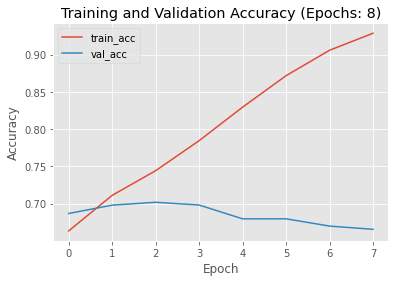

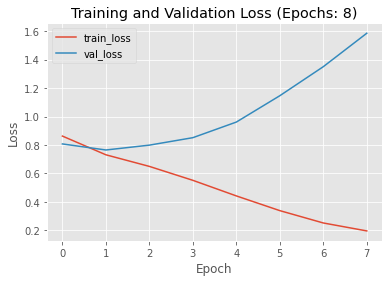

CPU times: user 17min 19s, sys: 51.5 s, total: 18min 11s
Wall time: 15min 18s


In [ ]:
%%time

model3_unbal_1 = Sequential(name="GloveClassification")

# embeddidng layer
model3_unbal_1.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim = EMBEDDING_DIM,
                    input_length=MAX_LEN_VECTOR,
                    weights=[glove_embedding_matrix],
                    trainable=False))

model3_unbal_1.add(LSTM(EMBEDDING_DIM,
                return_sequences=True,
                #recurrent_regularizer="l1_l2",
                #kernel_regularizer="l1_l2"
               ))

# Dense layers
model3_unbal_1.add(Dense(EMBEDDING_DIM, activation = 'relu'))

model3_unbal_1.add(Flatten())
model3_unbal_1.add(Dense(5, activation= tf.nn.softmax))

model3_unbal_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

evaluate_model(model3_unbal_1,
               epochs=20,
               train_tuple=(train_padded_sequences, y_train),
               validation_tuple=(val_padded_sequences, y_val),
               #test_tuple = (X_test, y_test),
               callbacks=[EarlyStopping(monitor='val_accuracy',
                                        mode='max',
                                        verbose=1,
                                        patience=5,
                                        restore_best_weights=True)],
               batch_size=32,
               labels=["1", "2", "3", "4", "5"]);

Epoch 1/100
4568/4568 [==============================] - 227s 49ms/step - loss: 1.0409 - accuracy: 0.6067 - val_loss: 0.9003 - val_accuracy: 0.6454
Epoch 2/100
4568/4568 [==============================] - 224s 49ms/step - loss: 0.8785 - accuracy: 0.6565 - val_loss: 0.8433 - val_accuracy: 0.6662
Epoch 3/100
4568/4568 [==============================] - 224s 49ms/step - loss: 0.8143 - accuracy: 0.6817 - val_loss: 0.8292 - val_accuracy: 0.6739
Epoch 4/100
4568/4568 [==============================] - 223s 49ms/step - loss: 0.7733 - accuracy: 0.6972 - val_loss: 0.8403 - val_accuracy: 0.6650
Epoch 5/100
4568/4568 [==============================] - 223s 49ms/step - loss: 0.7459 - accuracy: 0.7098 - val_loss: 0.8213 - val_accuracy: 0.6752
Epoch 6/100
4568/4568 [==============================] - 224s 49ms/step - loss: 0.7243 - accuracy: 0.7178 - val_loss: 0.8357 - val_accuracy: 0.6778
Epoch 7/100
4568/4568 [==============================] - 224s 49ms/step - loss: 0.7048 - accuracy: 0.7250 - val_

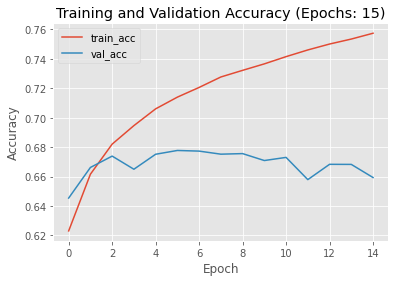

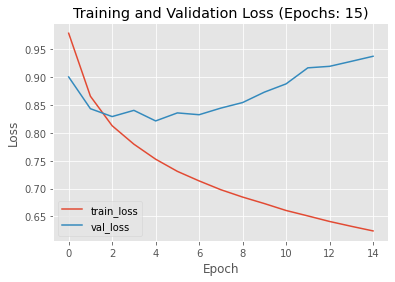

CPU times: user 1h 35min 18s, sys: 4min 6s, total: 1h 39min 24s
Wall time: 56min 35s


In [ ]:
%%time

model3 = Sequential(name="GloveClassification")

# embeddidng layer
model3.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim = EMBEDDING_DIM,
                    input_length=MAX_LEN_VECTOR,
                    weights=[glove_embedding_matrix],
                    trainable=False))

model3.add(LSTM(EMBEDDING_DIM,
                return_sequences=True,
                #recurrent_regularizer="l1_l2",
                #kernel_regularizer="l1_l2"
               ))

# Dense layers
model3.add(Dense(EMBEDDING_DIM, activation = 'relu'))

model3.add(Flatten())
model3.add(Dense(5, activation= tf.nn.softmax))

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

evaluate_model(model3,
               epochs=100,
               train_tuple=(train_padded_sequences, y_train),
               validation_tuple=(val_padded_sequences, y_val),
               #test_tuple = (X_test, y_test),
               callbacks=[EarlyStopping(monitor='val_accuracy',
                                        mode='max',
                                        verbose=1,
                                        patience=10,
                                        restore_best_weights=True)],
               batch_size=32,
               labels=["1", "2", "3", "4", "5"]);

Epoch 1/20
13310/13310 [==============================] - 327s 23ms/step - loss: 1.0903 - accuracy: 0.5272 - val_loss: 0.9089 - val_accuracy: 0.6360
Epoch 2/20
13310/13310 [==============================] - 301s 23ms/step - loss: 0.6772 - accuracy: 0.7268 - val_loss: 1.1022 - val_accuracy: 0.5565
Epoch 3/20
13310/13310 [==============================] - 303s 23ms/step - loss: 0.9517 - accuracy: 0.5942 - val_loss: 1.0850 - val_accuracy: 0.6545
Epoch 4/20
13310/13310 [==============================] - 307s 23ms/step - loss: 0.4310 - accuracy: 0.8289 - val_loss: 1.2473 - val_accuracy: 0.6281
Epoch 5/20
13310/13310 [==============================] - 306s 23ms/step - loss: 0.3434 - accuracy: 0.8637 - val_loss: 1.3450 - val_accuracy: 0.6226
Epoch 6/20
13310/13310 [==============================] - 300s 23ms/step - loss: 0.3709 - accuracy: 0.8510 - val_loss: 1.4491 - val_accuracy: 0.6562
Epoch 7/20
13310/13310 [==============================] - 302s 23ms/step - loss: 0.2583 - accuracy: 0.8988

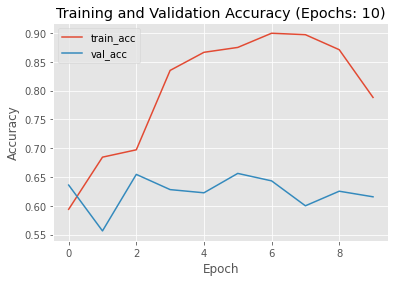

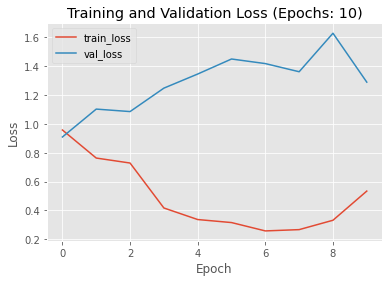

In [ ]:
model3_2 = Sequential(name="GloveClassification")

# embeddidng layer
model3_2.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim = EMBEDDING_DIM,
                    input_length=MAX_LEN_VECTOR,
                    weights=[glove_embedding_matrix],
                    trainable=False))

model3_2.add(LSTM(EMBEDDING_DIM, return_sequences=True, name='lstm_layer'))
model3_2.add(GlobalMaxPool1D())
model3_2.add(Dropout(0.1))
model3_2.add(Dense(50, activation="relu"))
model3_2.add(Dropout(0.1))

model3_2.add(Dense(5, activation= tf.nn.softmax))

model3_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

evaluate_model(model3_2,
               epochs=20,
               train_tuple=(train_padded_sequences_bal, y_train_res),
               validation_tuple=(val_padded_sequences, y_val),
               #test_tuple = (X_test, y_test),
               callbacks=[EarlyStopping(monitor='val_accuracy',
                                        mode='max',
                                        verbose=1,
                                        patience=4,
                                        restore_best_weights=True)],
               batch_size=32,
               labels=["1", "2", "3", "4", "5"]);

## Balanced classes

Epoch 1/20
13310/13310 [==============================] - 324s 24ms/step - loss: 1.0048 - accuracy: 0.5797 - val_loss: 1.2893 - val_accuracy: 0.5897
Epoch 2/20
13310/13310 [==============================] - 316s 24ms/step - loss: 0.3104 - accuracy: 0.8851 - val_loss: 1.5920 - val_accuracy: 0.6302
Epoch 3/20
13310/13310 [==============================] - 315s 24ms/step - loss: 0.1858 - accuracy: 0.9322 - val_loss: 2.0160 - val_accuracy: 0.6313
Epoch 4/20
13310/13310 [==============================] - 320s 24ms/step - loss: 0.1508 - accuracy: 0.9464 - val_loss: 2.4090 - val_accuracy: 0.6175
Epoch 5/20
13310/13310 [==============================] - 326s 24ms/step - loss: 0.1318 - accuracy: 0.9544 - val_loss: 2.5776 - val_accuracy: 0.6154
Epoch 6/20
13310/13310 [==============================] - 326s 25ms/step - loss: 0.1189 - accuracy: 0.9598 - val_loss: 2.9273 - val_accuracy: 0.6130
Epoch 7/20
13310/13310 [==============================] - 327s 25ms/step - loss: 0.1101 - accuracy: 0.9638

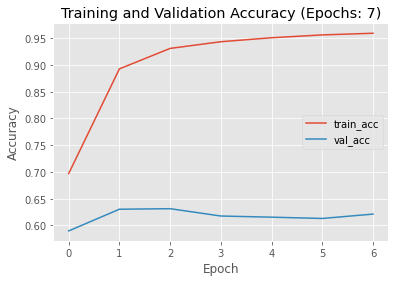

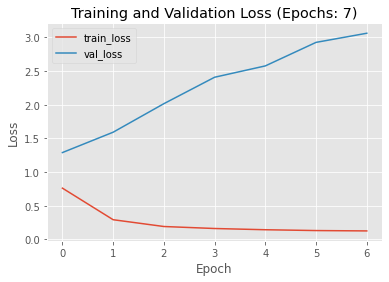

CPU times: user 42min 51s, sys: 2min 4s, total: 44min 56s
Wall time: 37min 42s


In [ ]:
%%time

model3_1_bal = Sequential(name="GloveClassification")

# embeddidng layer
model3_1_bal.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim = EMBEDDING_DIM,
                    input_length=MAX_LEN_VECTOR,
                    weights=[glove_embedding_matrix],
                    trainable=False))

model3_1_bal.add(LSTM(EMBEDDING_DIM,
                return_sequences=True,
                #recurrent_regularizer="l1_l2",
                #kernel_regularizer="l1_l2"
               ))

# Dense layers
model3_1_bal.add(Dense(EMBEDDING_DIM, activation = 'relu'))

model3_1_bal.add(Flatten())
model3_1_bal.add(Dense(5, activation= tf.nn.softmax))

model3_1_bal.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

evaluate_model(model3_1_bal,
               epochs=20,
               train_tuple=(train_padded_sequences_bal, y_train_res),
               validation_tuple=(val_padded_sequences, y_val),
               #test_tuple = (X_test, y_test),
               callbacks=[EarlyStopping(monitor='val_accuracy',
                                        mode='max',
                                        verbose=1,
                                        patience=4,
                                        restore_best_weights=True)],
               batch_size=32,
               labels=["1", "2", "3", "4", "5"]);

Epoch 1/20
13310/13310 [==============================] - 98s 7ms/step - loss: 1.2541 - accuracy: 0.4510 - val_loss: 1.0621 - val_accuracy: 0.5709
Epoch 2/20
13310/13310 [==============================] - 94s 7ms/step - loss: 0.9489 - accuracy: 0.6127 - val_loss: 1.1532 - val_accuracy: 0.5616
Epoch 3/20
13310/13310 [==============================] - 94s 7ms/step - loss: 0.8234 - accuracy: 0.6721 - val_loss: 1.1982 - val_accuracy: 0.5754
Epoch 4/20
13310/13310 [==============================] - 95s 7ms/step - loss: 0.7420 - accuracy: 0.7079 - val_loss: 1.2434 - val_accuracy: 0.5742
Epoch 5/20
13310/13310 [==============================] - 94s 7ms/step - loss: 0.6872 - accuracy: 0.7320 - val_loss: 1.3745 - val_accuracy: 0.5466
Epoch 6/20
13310/13310 [==============================] - 96s 7ms/step - loss: 0.6449 - accuracy: 0.7495 - val_loss: 1.3911 - val_accuracy: 0.5755
Epoch 7/20
13310/13310 [==============================] - 95s 7ms/step - loss: 0.6123 - accuracy: 0.7615 - val_loss: 1

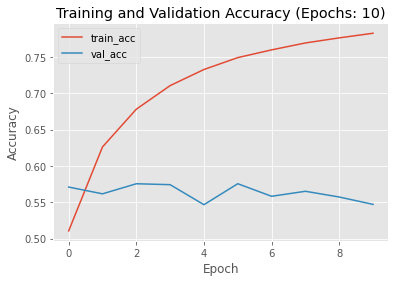

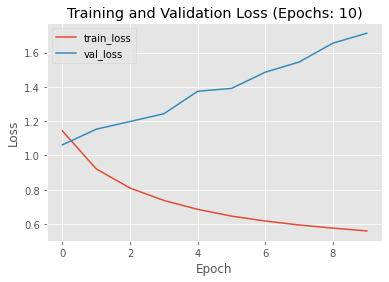

CPU times: user 20min 28s, sys: 2min 24s, total: 22min 53s
Wall time: 15min 52s


In [ ]:
%%time

model3_1 = Sequential(name="GloveClassification")

# embeddidng layer
model3_1.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim = EMBEDDING_DIM,
                    input_length=MAX_LEN_VECTOR,
                    weights=[glove_embedding_matrix],
                    trainable=False))

model3_1.add(LSTM(EMBEDDING_DIM,
                return_sequences=True,
                #recurrent_regularizer="l1_l2",
                #kernel_regularizer="l1_l2"
               ))

# Dense layers
model3_1.add(Dense(EMBEDDING_DIM, activation = 'relu'))

model3_1.add(Flatten())
model3_1.add(Dense(5, activation= tf.nn.softmax))

model3_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

evaluate_model(model3_1,
               epochs=20,
               train_tuple=(train_padded_sequences_bal, y_train_res),
               validation_tuple=(val_padded_sequences, y_val),
               #test_tuple = (X_test, y_test),
               callbacks=[EarlyStopping(monitor='val_accuracy',
                                        mode='max',
                                        verbose=1,
                                        patience=4,
                                        restore_best_weights=True)],
               batch_size=32,
               labels=["1", "2", "3", "4", "5"]);

Epoch 1/20
13310/13310 [==============================] - 97s 7ms/step - loss: 1.2983 - accuracy: 0.4233 - val_loss: 1.0483 - val_accuracy: 0.5747
Epoch 2/20
13310/13310 [==============================] - 94s 7ms/step - loss: 1.1095 - accuracy: 0.5141 - val_loss: 0.9734 - val_accuracy: 0.6038
Epoch 3/20
13310/13310 [==============================] - 95s 7ms/step - loss: 1.0577 - accuracy: 0.5396 - val_loss: 0.9572 - val_accuracy: 0.6036
Epoch 4/20
13310/13310 [==============================] - 95s 7ms/step - loss: 1.0221 - accuracy: 0.5553 - val_loss: 1.0274 - val_accuracy: 0.5788
Epoch 5/20
13310/13310 [==============================] - 98s 7ms/step - loss: 0.9920 - accuracy: 0.5737 - val_loss: 0.9923 - val_accuracy: 0.5809
Epoch 6/20
13310/13310 [==============================] - 97s 7ms/step - loss: 0.9642 - accuracy: 0.5848 - val_loss: 0.9993 - val_accuracy: 0.5907
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping


 ********* Training time: 834.43

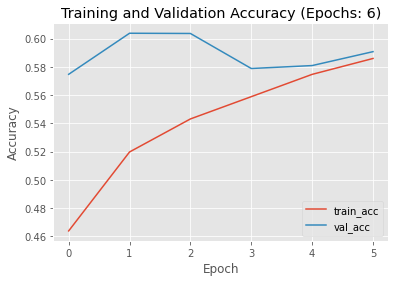

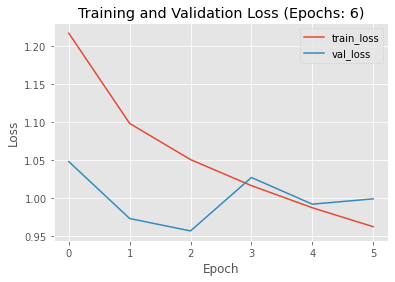

In [ ]:

model3_2 = Sequential(name="GloveClassification")

# embeddidng layer
model3_2.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim = EMBEDDING_DIM,
                    input_length=MAX_LEN_VECTOR,
                    weights=[glove_embedding_matrix],
                    trainable=False))

model3_2.add(LSTM(EMBEDDING_DIM, return_sequences=True, name='lstm_layer'))
model3_2.add(GlobalMaxPool1D())
model3_2.add(Dropout(0.1))
model3_2.add(Dense(50, activation="relu"))
model3_2.add(Dropout(0.1))

model3_2.add(Dense(5, activation= tf.nn.softmax))

model3_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

evaluate_model(model3_2,
               epochs=20,
               train_tuple=(train_padded_sequences_bal, y_train_res),
               validation_tuple=(val_padded_sequences, y_val),
               #test_tuple = (X_test, y_test),
               callbacks=[EarlyStopping(monitor='val_accuracy',
                                        mode='max',
                                        verbose=1,
                                        patience=4,
                                        restore_best_weights=True)],
               batch_size=32,
               labels=["1", "2", "3", "4", "5"]);

Epoch 1/20
13310/13310 [==============================] - 291s 21ms/step - loss: 1.2789 - accuracy: 0.4329 - val_loss: 0.9909 - val_accuracy: 0.5894
Epoch 2/20
13310/13310 [==============================] - 282s 21ms/step - loss: 0.9565 - accuracy: 0.5916 - val_loss: 1.1284 - val_accuracy: 0.5660
Epoch 3/20
13310/13310 [==============================] - 281s 21ms/step - loss: 0.7231 - accuracy: 0.7110 - val_loss: 1.2052 - val_accuracy: 0.6005
Epoch 4/20
13310/13310 [==============================] - 278s 21ms/step - loss: 0.5626 - accuracy: 0.7793 - val_loss: 1.3964 - val_accuracy: 0.5862
Epoch 5/20
13310/13310 [==============================] - 275s 21ms/step - loss: 0.4796 - accuracy: 0.8116 - val_loss: 1.4929 - val_accuracy: 0.5774
Epoch 6/20
13310/13310 [==============================] - 282s 21ms/step - loss: 0.4269 - accuracy: 0.8314 - val_loss: 1.5806 - val_accuracy: 0.5943
Epoch 7/20
13310/13310 [==============================] - 282s 21ms/step - loss: 0.3964 - accuracy: 0.8428

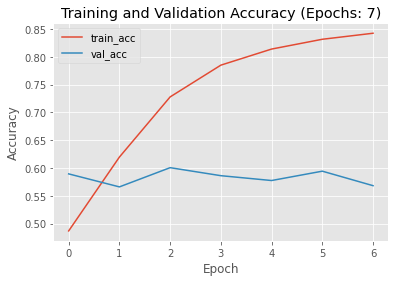

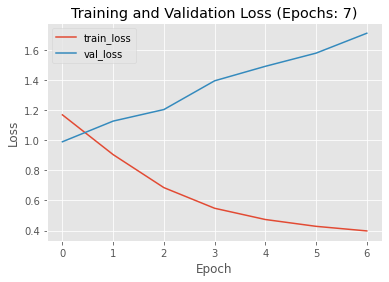

CPU times: user 40min 7s, sys: 4min 5s, total: 44min 13s
Wall time: 32min 57s


In [ ]:
%%time
model3_3 = Sequential([
    Embedding(input_dim=len(word_index) + 1,
                    output_dim = EMBEDDING_DIM,
                    input_length=MAX_LEN_VECTOR,
                    weights=[glove_embedding_matrix],
                    trainable=False),
    Bidirectional(LSTM(EMBEDDING_DIM, return_sequences=True)),
    Bidirectional(LSTM(EMBEDDING_DIM,)),
    Dense(EMBEDDING_DIM, activation='relu'),
    Dense(5, activation='softmax')
])

model3_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

evaluate_model(model3_3,
               epochs=20,
               train_tuple=(train_padded_sequences_bal, y_train_res),
               validation_tuple=(val_padded_sequences, y_val),
               #test_tuple = (X_test, y_test),
               callbacks=[EarlyStopping(monitor='val_accuracy',
                                        mode='max',
                                        verbose=1,
                                        patience=4,
                                        restore_best_weights=True)],
               batch_size=32,
               labels=["1", "2", "3", "4", "5"]);

# 4

Utiliza el modelo BERT basado en Transformers para clasificación de enunciados y la librería HuggingFace, obtener un modelo de clasificación de los comentarios de Amazon_Baby. Deberás usar la misma partición del documento en conjuntos de entrenamiento, validación y prueba utilizada en el ejercicio anterior.

NOTA: Debes usar la partición en su forma de texto plano, y no en su forma embebida. Puedes apoyarte en el ejemplo para el caso de reseña de las películas IMBD que se incluye en: https://huggingface.co/transformers/custom_datasets.html#sequenceclassification-with-imdb-reviews.

---

Se reducirá la cantidad de vectores máximos a 200 dimensiones para poder optimizar recursos y tiempo de entrenamiento.

In [ ]:
from transformers import DistilBertTokenizerFast

bert_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

BERT_MAX_VECTOR = 200

# Text to sequences

train_encodings_pt = bert_tokenizer(X_train.tolist(),
                                    truncation=True,
                                    padding=True,
                                    max_length=BERT_MAX_VECTOR,
                                    return_tensors="pt")
val_encodings_pt = bert_tokenizer(X_val.tolist(),
                                  truncation=True,
                                  padding=True,
                                  max_length=BERT_MAX_VECTOR,
                                  return_tensors="pt")
test_encodings_pt = bert_tokenizer(X_test.tolist(),
                                   truncation=True,
                                   padding=True,
                                   max_length=BERT_MAX_VECTOR,
                                   return_tensors="pt")


## Pytorch preparations

In [ ]:
import torch

class AmazonBabyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset_pt = AmazonBabyDataset(train_encodings_pt, y_train)
val_dataset_pt = AmazonBabyDataset(val_encodings_pt, y_val)
test_dataset_pt = AmazonBabyDataset(test_encodings_pt, y_test)

## Modelo 1

El siguiente modelo usa un dataset no-balanceado

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    
    # Turn to true labels
    predictions = np.argmax(logits, axis=1)
    
    # Turn one-hot encoding to discrete values too
    y_true = np.argmax(labels, axis=1)
    
    #print(f"logits: {logits.shape}")
    #print(f"y_true: {y_true.shape}")
    #print(f"Predictions: {predictions.shape}")
    return metric.compute(predictions=predictions, references=y_true)

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=20,              # total number of training epochs
    per_device_train_batch_size=128,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    evaluation_strategy="epoch",
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
)

model_pt = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",
                                                            num_labels=5)

trainer_pt = Trainer(
    model=model_pt,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset_pt,         # training dataset
    eval_dataset=val_dataset_pt,             # evaluation dataset
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=4)],
)

print_marquee("Training Results")

training_output_pt = trainer_pt.train()

display(training_output_pt)

# Trainin Confusion Matrix
display(training_output_pt)
train_pred_output = trainer_pt.predict(train_dataset_pt)
print_dataset_prediction_report(train_pred_output.predictions.argmax(axis=1),
                                y_train.argmax(axis=1),
                                ["1", "2", "3", "4", "5"])

print_marquee("Validation Results")

# Validation Confusion Matrix
val_pred_output = trainer_pt.predict(val_dataset_pt)
print_dataset_prediction_report(val_pred_output.predictions.argmax(axis=1),
                                y_val.argmax(axis=1),
                                ["1", "2", "3", "4", "5"])

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier



********************
* Training Results *
********************


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Epoch,Training Loss,Validation Loss,Accuracy
1,0.250700,0.243586,0.718555
2,0.228400,0.238670,0.730378
3,0.194800,0.255940,0.723098
4,0.161200,0.288612,0.720690
5,0.126300,0.315014,0.707937
6,0.106800,0.353950,0.713519


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to us

TrainOutput(global_step=6852, training_loss=0.1811689089698814, metrics={'train_runtime': 8656.0683, 'train_samples_per_second': 2.639, 'total_flos': 0, 'epoch': 6.0, 'init_mem_cpu_alloc_delta': 1828216832, 'init_mem_gpu_alloc_delta': 268962304, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 31014912, 'train_mem_gpu_alloc_delta': 806371840, 'train_mem_cpu_peaked_delta': 0, 'train_mem_gpu_peaked_delta': 13457149440})

TrainOutput(global_step=6852, training_loss=0.1811689089698814, metrics={'train_runtime': 8656.0683, 'train_samples_per_second': 2.639, 'total_flos': 0, 'epoch': 6.0, 'init_mem_cpu_alloc_delta': 1828216832, 'init_mem_gpu_alloc_delta': 268962304, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 31014912, 'train_mem_gpu_alloc_delta': 806371840, 'train_mem_cpu_peaked_delta': 0, 'train_mem_gpu_peaked_delta': 13457149440})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':




*************************
* Classification Report *
*************************
              precision    recall  f1-score   support

           1       0.67      0.87      0.75     12086
           2       0.53      0.33      0.40      9005
           3       0.63      0.52      0.57     13488
           4       0.70      0.57      0.63     26399
           5       0.88      0.96      0.92     85180

    accuracy                           0.80    146158
   macro avg       0.68      0.65      0.65    146158
weighted avg       0.79      0.80      0.79    146158



********************
* Confusion Matrix *
********************
[[10500   928   452    65   141]
 [ 3652  2933  1987   260   173]
 [ 1184  1555  7002  2990   757]
 [  251   108  1452 15017  9571]
 [  163    19   198  3270 81530]]


**********************
* Validation Results *
**********************


*************************
* Classification Report *
*************************
              precision    recall  f1-score   sup

## Modelo 2

El siguiente modelo usó un dataset que fue balanceado con Oversampling con respecto a la clase mayoritaria sólo en el conjunto de entrenamiento.

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    
    # Turn to true labels
    predictions = np.argmax(logits, axis=1)
    
    # Turn one-hot encoding to discrete values too
    y_true = np.argmax(labels, axis=1)
    
    #print(f"logits: {logits.shape}")
    #print(f"y_true: {y_true.shape}")
    #print(f"Predictions: {predictions.shape}")
    return metric.compute(predictions=predictions, references=y_true)

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=20,              # total number of training epochs
    per_device_train_batch_size=128,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    evaluation_strategy="epoch",
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
)

model_pt = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",
                                                            num_labels=5)

trainer_pt = Trainer(
    model=model_pt,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset_pt,         # training dataset
    eval_dataset=val_dataset_pt,             # evaluation dataset
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=4)],
)

print_marquee("Training Results")

training_output_pt = trainer_pt.train()

display(training_output_pt)

# Trainin Confusion Matrix
display(training_output_pt)
train_pred_output = trainer_pt.predict(train_dataset_pt)
print_dataset_prediction_report(train_pred_output.predictions.argmax(axis=1),
                                y_train.argmax(axis=1),
                                ["1", "2", "3", "4", "5"])

print_marquee("Validation Results")

# Validation Confusion Matrix
val_pred_output = trainer_pt.predict(val_dataset_pt)
print_dataset_prediction_report(val_pred_output.predictions.argmax(axis=1),
                                y_val.argmax(axis=1),
                                ["1", "2", "3", "4", "5"])

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_clas



********************
* Training Results *
********************


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Epoch,Training Loss,Validation Loss,Accuracy
1,0.172800,0.361992,0.641325
2,0.100700,0.410864,0.648550
3,0.066200,0.441042,0.670608
4,0.044100,0.483457,0.694198
5,0.035300,0.536731,0.664204
6,0.026000,0.604499,0.682047
7,0.017200,0.645109,0.673673
8,0.012500,0.683874,0.675862


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to us

TrainOutput(global_step=26624, training_loss=0.07587604577957581, metrics={'train_runtime': 8845.1965, 'train_samples_per_second': 7.525, 'total_flos': 0, 'epoch': 8.0, 'init_mem_cpu_alloc_delta': 2087804928, 'init_mem_gpu_alloc_delta': 268962304, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 5804032, 'train_mem_gpu_alloc_delta': 813712384, 'train_mem_cpu_peaked_delta': 18747392, 'train_mem_gpu_peaked_delta': 4752630784})

TrainOutput(global_step=26624, training_loss=0.07587604577957581, metrics={'train_runtime': 8845.1965, 'train_samples_per_second': 7.525, 'total_flos': 0, 'epoch': 8.0, 'init_mem_cpu_alloc_delta': 2087804928, 'init_mem_gpu_alloc_delta': 268962304, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 5804032, 'train_mem_gpu_alloc_delta': 813712384, 'train_mem_cpu_peaked_delta': 18747392, 'train_mem_gpu_peaked_delta': 4752630784})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':




*************************
* Classification Report *
*************************
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     85180
           2       0.99      1.00      1.00     85180
           3       0.99      1.00      1.00     85180
           4       0.98      0.96      0.97     85180
           5       0.97      0.97      0.97     85180

    accuracy                           0.99    425900
   macro avg       0.99      0.99      0.99    425900
weighted avg       0.99      0.99      0.99    425900



********************
* Confusion Matrix *
********************
[[85123    22     4    13    18]
 [   14 85155     0    11     0]
 [   37   141 84837   122    43]
 [   91    95   104 82058  2832]
 [  136   177   328  1573 82966]]


**********************
* Validation Results *
**********************


*************************
* Classification Report *
*************************
              precision    recall  f1-score   sup

## Modelo 3

El siguiente modelo se entrenó haciendo Oversampling a todo el dataset, de modo que training, validation y test también fueron balanceados.

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    
    # Turn to true labels
    predictions = np.argmax(logits, axis=1)
    
    # Turn one-hot encoding to discrete values too
    y_true = np.argmax(labels, axis=1)
    
    #print(f"logits: {logits.shape}")
    #print(f"y_true: {y_true.shape}")
    #print(f"Predictions: {predictions.shape}")
    return metric.compute(predictions=predictions, references=y_true)

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=128,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    evaluation_strategy="epoch",
    metric_for_best_model="loss",
    load_best_model_at_end=True,
)

model_pt = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",
                                                            num_labels=5)

trainer_pt = Trainer(
    model=model_pt,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset_pt,         # training dataset
    eval_dataset=val_dataset_pt,             # evaluation dataset
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
)

training_output_pt = trainer_pt.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.w

Epoch,Training Loss,Validation Loss,Accuracy
1,0.191700,0.167591,0.832795
2,0.120800,0.117358,0.886664


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


In [ ]:
# Validation Confusion Matrix
display(training_output_pt)
val_pred_output = trainer_pt.predict(val_dataset_pt)
print_dataset_prediction_report(val_pred_output.predictions.argmax(axis=1),
                                y_val.argmax(axis=1),
                                ["1", "2", "3", "4", "5"])

TrainOutput(global_step=9984, training_loss=0.15370755375195772, metrics={'train_runtime': 3613.9135, 'train_samples_per_second': 2.763, 'total_flos': 0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 2275229696, 'init_mem_gpu_alloc_delta': 268962304, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 118013952, 'train_mem_gpu_alloc_delta': 807100416, 'train_mem_cpu_peaked_delta': 4186112, 'train_mem_gpu_peaked_delta': 5421223936})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':




*************************
* Classification Report *
*************************
              precision    recall  f1-score   support

           1       0.98      0.96      0.97     85180
           2       0.95      0.98      0.96     85180
           3       0.91      0.91      0.91     85180
           4       0.75      0.81      0.78     85180
           5       0.84      0.77      0.80     85180

    accuracy                           0.88    425900
   macro avg       0.89      0.88      0.88    425900
weighted avg       0.89      0.88      0.88    425900



********************
* Confusion Matrix *
********************
[[81686  1832  1352   132   178]
 [  645 83072  1159   195   109]
 [  438  1978 77356  4955   453]
 [  120   435  3638 69107 11880]
 [  282   285  1685 17504 65424]]


## Modelo 5

Undersampling en el conjunto de entrenamiento

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    
    # Turn to true labels
    predictions = np.argmax(logits, axis=1)
    
    # Turn one-hot encoding to discrete values too
    y_true = np.argmax(labels, axis=1)
    
    #print(f"logits: {logits.shape}")
    #print(f"y_true: {y_true.shape}")
    #print(f"Predictions: {predictions.shape}")
    return metric.compute(predictions=predictions, references=y_true)

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=20,              # total number of training epochs
    per_device_train_batch_size=64,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    evaluation_strategy="epoch",
    metric_for_best_model="loss",
    load_best_model_at_end=True,
)

model_pt = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",
                                                            num_labels=5)

trainer_pt = Trainer(
    model=model_pt,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset_pt,         # training dataset
    eval_dataset=val_dataset_pt,             # evaluation dataset
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
)

training_output_pt = trainer_pt.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier

Epoch,Training Loss,Validation Loss,Accuracy
1,0.366400,0.355263,0.546116
2,0.331100,0.370561,0.526250
3,0.281200,0.382298,0.544519
4,0.223000,0.410296,0.535119
5,0.166500,0.474525,0.531217
6,0.131300,0.532577,0.527315


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to us

In [ ]:
training_output_pt

TrainOutput(global_step=4230, training_loss=0.2549166988255566, metrics={'train_runtime': 1475.7797, 'train_samples_per_second': 9.554, 'total_flos': 0, 'epoch': 6.0, 'init_mem_cpu_alloc_delta': 1849470976, 'init_mem_gpu_alloc_delta': 268962304, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 113221632, 'train_mem_gpu_alloc_delta': 807114752, 'train_mem_cpu_peaked_delta': 0, 'train_mem_gpu_peaked_delta': 2368857088})

In [ ]:
trainer_pt.evaluate()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


{'epoch': 6.0,
 'eval_accuracy': 0.5461156438453352,
 'eval_loss': 0.355262815952301,
 'eval_mem_cpu_alloc_delta': 77824,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 150069248,
 'eval_runtime': 10.2279,
 'eval_samples_per_second': 551.235}

# 5

Con el mejor modelo que hayas encontrado en los ejercicios 3 y 4, obtener el desempeño del conjunto de prueba. Incluye las conclusiones de los resultados obtenidos.

In [ ]:
review_labels = ["1", "2", "3", "4", "5"]

## LSTM Predictions

In [ ]:
print_marquee("LSTM Validation Dataset Confusion Matrix")

lstm_test_pred = model3_unbal_1.predict(test_padded_sequences,
                                  batch_size=32)

print_dataset_prediction_report(lstm_test_pred.argmax(axis=1),
                                y_test.argmax(axis=1),
                                review_labels)



********************************************
* LSTM Validation Dataset Confusion Matrix *
********************************************


*************************
* Classification Report *
*************************
              precision    recall  f1-score   support

           1       0.61      0.71      0.65      1537
           2       0.36      0.16      0.22      1127
           3       0.40      0.32      0.36      1626
           4       0.55      0.28      0.38      3346
           5       0.78      0.95      0.86     10634

    accuracy                           0.70     18270
   macro avg       0.54      0.48      0.49     18270
weighted avg       0.66      0.70      0.67     18270



********************
* Confusion Matrix *
********************
[[ 1092   138   133    18   156]
 [  399   176   295    81   176]
 [  202   113   527   306   478]
 [   56    43   267   951  2029]
 [   50    15   111   363 10095]]


In [ ]:
print_marquee("LSTM Validation Dataset Confusion Matrix")

lstm_test_pred = model3_3.predict(test_padded_sequences,
                                  batch_size=32)

print_dataset_prediction_report(lstm_test_pred.argmax(axis=1),
                                y_test.argmax(axis=1),
                                review_labels)



***************************************
* Validation Dataset Confusion Matrix *
***************************************


*************************
* Classification Report *
*************************
              precision    recall  f1-score   support

           1       0.53      0.54      0.54      1537
           2       0.25      0.36      0.29      1127
           3       0.25      0.39      0.31      1626
           4       0.38      0.39      0.38      3346
           5       0.86      0.73      0.79     10634

    accuracy                           0.60     18270
   macro avg       0.45      0.48      0.46     18270
weighted avg       0.65      0.60      0.62     18270



********************
* Confusion Matrix *
********************
[[ 834  398  207   52   46]
 [ 287  406  291   90   53]
 [ 160  355  640  311  160]
 [ 103  204  698 1295 1046]
 [ 191  287  722 1646 7788]]


## HuggingFace Pytorch predictions

### No balancing of dataset

In [ ]:
test_pred_output = trainer_pt.predict(test_dataset_pt)
print_dataset_prediction_report(test_pred_output.predictions.argmax(axis=1),
                                y_test.argmax(axis=1),
                                review_labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':




*************************
* Classification Report *
*************************
              precision    recall  f1-score   support

           1       0.62      0.79      0.69      1537
           2       0.40      0.23      0.29      1127
           3       0.45      0.37      0.41      1626
           4       0.55      0.44      0.49      3346
           5       0.84      0.92      0.87     10634

    accuracy                           0.73     18270
   macro avg       0.57      0.55      0.55     18270
weighted avg       0.70      0.73      0.71     18270



********************
* Confusion Matrix *
********************
[[1210  152   85   24   66]
 [ 422  258  286   87   74]
 [ 174  183  607  400  262]
 [  63   34  269 1460 1520]
 [  90   13   98  677 9756]]


### Oversampling just the Train set

In [ ]:
# Oversampling just the X_train
test_pred_output = trainer_pt.predict(test_dataset_pt)
print_dataset_prediction_report(test_pred_output.predictions.argmax(axis=1),
                                y_test.argmax(axis=1),
                                review_labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':




*************************
* Classification Report *
*************************
              precision    recall  f1-score   support

           1       0.64      0.61      0.62      1537
           2       0.32      0.37      0.34      1127
           3       0.39      0.33      0.36      1626
           4       0.47      0.38      0.42      3346
           5       0.82      0.88      0.85     10634

    accuracy                           0.69     18270
   macro avg       0.53      0.52      0.52     18270
weighted avg       0.67      0.69      0.68     18270



********************
* Confusion Matrix *
********************
[[ 935  393   80   42   87]
 [ 285  418  233   79  112]
 [ 121  335  544  354  272]
 [  44  110  381 1282 1529]
 [  86   68  142  997 9341]]


### Oversampling the whole dataset

In [ ]:
# Oversampling whole dataset
pred_output = trainer_pt.predict(test_dataset_pt)
print_dataset_prediction_report(pred_output.predictions.argmax(axis=1),
                                y_test.argmax(axis=1),
                                review_labels)



*************************
* Classification Report *
*************************
              precision    recall  f1-score   support

           1       0.98      0.97      0.97     10634
           2       0.96      0.98      0.97     10571
           3       0.90      0.94      0.92     10633
           4       0.78      0.77      0.77     10596
           5       0.82      0.79      0.80     10806

    accuracy                           0.89     53240
   macro avg       0.89      0.89      0.89     53240
weighted avg       0.89      0.89      0.89     53240



********************
* Confusion Matrix *
********************
[[10326   130   145    21    12]
 [   57 10346   122    39     7]
 [   81   157  9980   352    63]
 [   36    57   599  8126  1778]
 [   76    42   257  1941  8490]]


# Conclusiones

Con base en los resultados, se observa que si bien el dataset está muy desbalanceado hacia los reviews de 5 estrellas, hace un oversampling introduce mucho ruido que hace que el performance del modelo baje y si se hace un undersampling con respecto a la clase menos representada, se produce un efecto donde el modelo baja su accuracy a los a los 50%.

En este casos se obtuvieron los mejores resultados con un Train/Val/Test split de 80/10/10 sin hacer un balance de clases.

El balance de clases antes de hacer split, sobre todo con oversampling, tuvo un efecto donde el accuracy en los 3 splits alcanzó casi el 90% de accuracy, sin embargo esto puede ser engañoso por la manera en que actúa oversampling, que hace una elección de elementos al azar con reemplazo. Al hacer el oversampling antes del split, se corre el riesgo de tener un *data leakage* en cada uno de los splits. En otras palabras, puede darse el caso que elementos que deberían pertenecer exclusivamente al dataset de prueba, pueden estar siendo usados por el dataset de entrenamiento.

Finalmente, el aumento de dimensiones con GloVe permite tener mejores resultados a expensas de mayor tiempo y mayor uso de recursos. En contraposición, usando menos dimensiones con un modelo BERT pre-entrenado permite tener mejores resultados que una RNN LSTM incluso con 100 dimensiones menos.

Los resultados de clasificación entre los datasets de validación y de prueba se mantienen equiparables, por lo que se puede afirmar que el modelo está generalizando apropiadamente a datos nunca antes vistos. EarlyStopping permite parar el fenómeno de sobre-entrenamiento que, en algunos casos, se pudo haber disparado considerablemente.
